# Assignment-4

**Due Date:** 05.01.2024

---------------------------------------

**Instructor:** Ali Seydi KEÇELİ

**TA:** Görkem Akyıldız

---------------------------------------
**Student Name Surname**: Melike Nur DULKADİR
**Student ID**: 21992919

In [1]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import imutils
import warnings

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input
from sklearn.metrics import accuracy_score


warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load Images

Images are loaded from the specified dataset path, organized into training, testing, and validation sets, and then resized to 128x128 pixels. The data is normalized, and the function returns arrays containing the images and their corresponding labels for each set in a passive voice construction.

In [233]:
def load_images(dataset_path):
    """
    Loads images from the specified dataset path, resizes them, and splits into training, testing, and validation sets.

    Parameters:
    - dataset_path: Path to the dataset.

    Returns:
    - Tuple containing arrays of training images, training labels, testing images, testing labels, validation images, and validation labels.
    """
    folders = [folder_name for folder_name in os.listdir(dataset_path)
               if os.path.isdir(os.path.join(dataset_path, folder_name))]
    train_images, test_images, validation_images = [], [], []
    train_labels, test_labels, validation_labels = [], [], []
    for folder_name in folders:
        folder_path = os.path.join(dataset_path, folder_name)
        images = [os.path.join(folder_path, image_name) for image_name in os.listdir(folder_path) if image_name.endswith('.jpg')]
        if len(images) > 300:
            random.shuffle(images)
            train, test, validation = [],[],[]
            for image in images:
                try:
                    img = cv2.imread(image)
                    img = cv2.resize(img, (128, 128))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_array = np.array(img)
                    img_array = img_array / 255.0
                    if len(train)<200:
                        train.append(img_array)
                        train_images.append(img_array)
                        train_labels.append(folder_name)
                    elif len(train)==200 and len(test)<50:
                        test.append(img_array)
                        test_images.append(img_array)
                        test_labels.append(folder_name)
                    elif len(train) == 200 and len(test) == 50 and len(validation) < 50:
                        validation.append(img_array)
                        validation_images.append(img_array)
                        validation_labels.append(folder_name)
                except Exception as e:
                    continue
    
    return train_images, train_labels, test_images,test_labels, validation_images, validation_labels

In [234]:
dataset_path = 'Images'
train_images,train_labels,test_images,test_labels,validation_images,validation_labels= load_images(dataset_path)

# Preprocessing

Label encoding is applied to the training, testing, and validation labels using the LabelEncoder, transforming the original label arrays into encoded representations.

In [235]:
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)

# Util Functions

Graphs depicting training and validation loss in the left subplot and training and validation accuracy in the right subplot are plotted using the provided history object. The function then displays these graphs in a single figure with two subplots.

In [238]:
def plot_graphs(history):
    """
    Plots training and validation loss in the left subplot and training and validation accuracy in the right subplot.

    Parameters:
    - history: Training history obtained from model training.

    Returns:
    - None
    """
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

The function generates and displays a confusion matrix for the model's predictions on test images using a heatmap representation. The x-axis shows predicted labels, the y-axis shows true labels, and each cell represents the count of instances where the true and predicted labels intersect

In [268]:
def plot_confusion_matrix(model,test_images,test_labels_encoded):
    """
    Plots the confusion matrix for model predictions on test images.

    Parameters:
    - model: Trained model for predictions.
    - test_images: Test images for prediction.
    - test_labels_encoded: Encoded true labels corresponding to test images.

    Returns:
    - None
    """
    test_predictions = model.predict(np.array(test_images))
    conf_matrix = confusion_matrix(np.array(test_labels_encoded), np.argmax(test_predictions, axis=1))
    
    
    plt.figure(figsize=(10, 8)) 
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Case 2_1')
    plt.colorbar()
    
    classes = label_encoder.classes_
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# CNN Architectures for Part 1

A convolutional neural network (CNN) model is created with three convolutional layers followed by max-pooling layers, a flatten layer, and two fully connected layers. The model is compiled with the Adam optimizer, sparse categorical crossentropy loss, and accuracy as the metric. The input shape, number of classes, and learning rate are configurable parameters.

In [236]:
def create_cnn_model(input_shape=(128, 128, 3), num_classes=15,learning_rate=0.001):
    """
    Creates a convolutional neural network (CNN) model for image classification.

    Parameters:
    - input_shape: Tuple representing the input shape of the images.
    - num_classes: Number of classes for classification.
    - learning_rate: Learning rate for the Adam optimizer.

    Returns:
    - Compiled CNN model.
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

A CNN model with dropout regularization is created, incorporating three convolutional layers, max-pooling layers, a flatten layer, a dense layer with ReLU activation, a dropout layer with the specified dropout rate, and a final dense layer with softmax activation. The model is compiled using the Adam optimizer, sparse categorical crossentropy loss, and accuracy as the metric. Input shape, number of classes, dropout rate, and learning rate are configurable parameters.

In [237]:
def create_cnn_model_with_dropout(input_shape=(128, 128, 3), num_classes=15, dropout_rate=0.5,learning_rate=0.001):
    """
    Creates a convolutional neural network (CNN) model with dropout for image classification.

    Parameters:
    - input_shape: Tuple representing the input shape of the images.
    - num_classes: Number of classes for classification.
    - dropout_rate: Dropout rate for regularization.
    - learning_rate: Learning rate for the Adam optimizer.

    Returns:
    - Compiled CNN model with dropout.
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

# Experiment with a learning rate of 0.001 and a batch size of 32

In [85]:
model1 = create_cnn_model((128, 128, 3),15,0.001)

In [86]:
history1 = model1.fit(np.array(train_images), np.array(train_labels_encoded),
                    epochs=100, batch_size=32, validation_data=(np.array(test_images), np.array(test_labels_encoded)))

Epoch 1/100
94/94 [==============================] - 14s 128ms/step - loss: 2.5184 - accuracy: 0.1390 - val_loss: 2.4302 - val_accuracy: 0.1747
Epoch 2/100
94/94 [==============================] - 11s 115ms/step - loss: 2.1604 - accuracy: 0.2600 - val_loss: 2.0876 - val_accuracy: 0.2760
Epoch 3/100
94/94 [==============================] - 11s 116ms/step - loss: 1.9218 - accuracy: 0.3510 - val_loss: 2.0678 - val_accuracy: 0.2973
Epoch 4/100
94/94 [==============================] - 11s 113ms/step - loss: 1.7271 - accuracy: 0.4197 - val_loss: 2.0821 - val_accuracy: 0.3133
Epoch 5/100
94/94 [==============================] - 11s 114ms/step - loss: 1.4206 - accuracy: 0.5220 - val_loss: 2.1705 - val_accuracy: 0.3387
Epoch 6/100
94/94 [==============================] - 11s 113ms/step - loss: 1.0493 - accuracy: 0.6543 - val_loss: 2.2809 - val_accuracy: 0.3133
Epoch 7/100
94/94 [==============================] - 10s 112ms/step - loss: 0.6982 - accuracy: 0.7793 - val_loss: 2.7196 - val_accuracy:

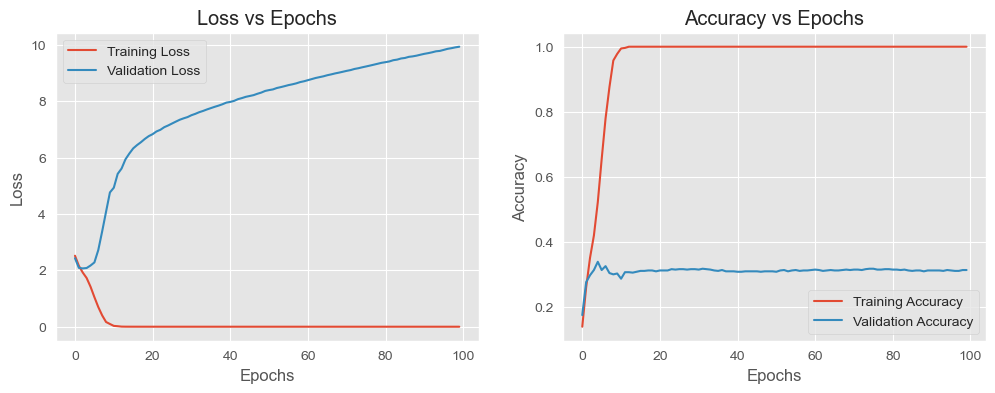

In [87]:
plot_graphs(history1)

In [88]:
test_loss1, test_accuracy1 = model1.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Test Loss: {test_loss1}, Test Accuracy: {test_accuracy1}")

24/24 [==============================] - 1s 31ms/step - loss: 9.9312 - accuracy: 0.3133
Test Loss: 9.931163787841797, Test Accuracy: 0.31333333253860474


# Experiment with a learning rate of 0.001 and a batch size of 64

In [89]:
model2 = create_cnn_model((128, 128, 3),15,0.001)

In [90]:
history2 = model2.fit(np.array(train_images), np.array(train_labels_encoded),
                      epochs=100, batch_size=64, validation_data=(np.array(test_images), np.array(test_labels_encoded)))

Epoch 1/100
47/47 [==============================] - 11s 212ms/step - loss: 2.6292 - accuracy: 0.0943 - val_loss: 2.4589 - val_accuracy: 0.1493
Epoch 2/100
47/47 [==============================] - 9s 200ms/step - loss: 2.2689 - accuracy: 0.2383 - val_loss: 2.2296 - val_accuracy: 0.2560
Epoch 3/100
47/47 [==============================] - 9s 201ms/step - loss: 2.0389 - accuracy: 0.3280 - val_loss: 2.1276 - val_accuracy: 0.2640
Epoch 4/100
47/47 [==============================] - 9s 200ms/step - loss: 1.8337 - accuracy: 0.3880 - val_loss: 2.1350 - val_accuracy: 0.2853
Epoch 5/100
47/47 [==============================] - 9s 201ms/step - loss: 1.6327 - accuracy: 0.4653 - val_loss: 2.0868 - val_accuracy: 0.3107
Epoch 6/100
47/47 [==============================] - 9s 201ms/step - loss: 1.4016 - accuracy: 0.5410 - val_loss: 2.2108 - val_accuracy: 0.2960
Epoch 7/100
47/47 [==============================] - 9s 200ms/step - loss: 1.0569 - accuracy: 0.6740 - val_loss: 2.3845 - val_accuracy: 0.314

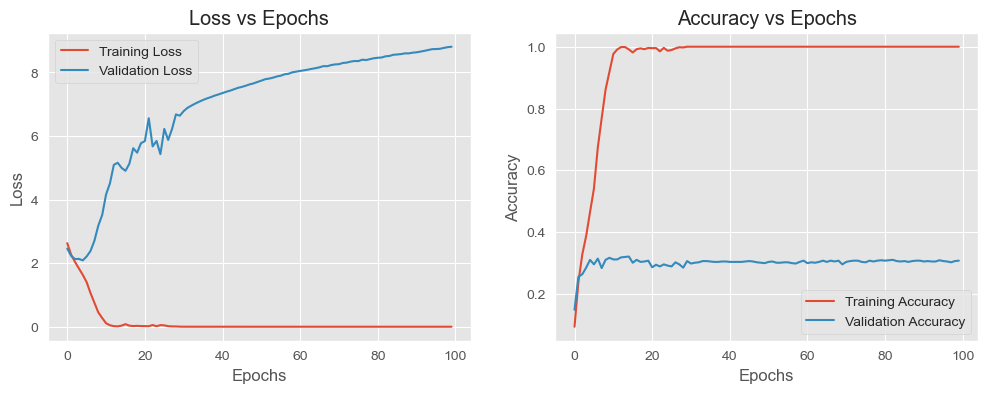

In [91]:
plot_graphs(history2)

In [92]:
test_loss2, test_accuracy2 = model2.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Test Loss: {test_loss2}, Test Accuracy: {test_accuracy2}")

24/24 [==============================] - 1s 32ms/step - loss: 8.8093 - accuracy: 0.3080
Test Loss: 8.80933952331543, Test Accuracy: 0.30799999833106995


# Experiment with a learning rate of 0.01 and a batch size of 32

In [93]:
model3 = create_cnn_model((128, 128, 3),15,0.01)

In [94]:
history3 = model3.fit(np.array(train_images), np.array(train_labels_encoded),
                      epochs=100, batch_size=32, validation_data=(np.array(test_images), np.array(test_labels_encoded)))

Epoch 1/100
94/94 [==============================] - 12s 114ms/step - loss: 3.5283 - accuracy: 0.0610 - val_loss: 2.7083 - val_accuracy: 0.0667
Epoch 2/100
94/94 [==============================] - 10s 108ms/step - loss: 2.7103 - accuracy: 0.0583 - val_loss: 2.7082 - val_accuracy: 0.0667
Epoch 3/100
94/94 [==============================] - 10s 110ms/step - loss: 2.7103 - accuracy: 0.0543 - val_loss: 2.7083 - val_accuracy: 0.0667
Epoch 4/100
94/94 [==============================] - 10s 109ms/step - loss: 2.7102 - accuracy: 0.0590 - val_loss: 2.7082 - val_accuracy: 0.0667
Epoch 5/100
94/94 [==============================] - 10s 109ms/step - loss: 2.7102 - accuracy: 0.0560 - val_loss: 2.7081 - val_accuracy: 0.0667
Epoch 6/100
94/94 [==============================] - 10s 109ms/step - loss: 2.7108 - accuracy: 0.0553 - val_loss: 2.7083 - val_accuracy: 0.0667
Epoch 7/100
94/94 [==============================] - 10s 108ms/step - loss: 2.7100 - accuracy: 0.0593 - val_loss: 2.7082 - val_accuracy:

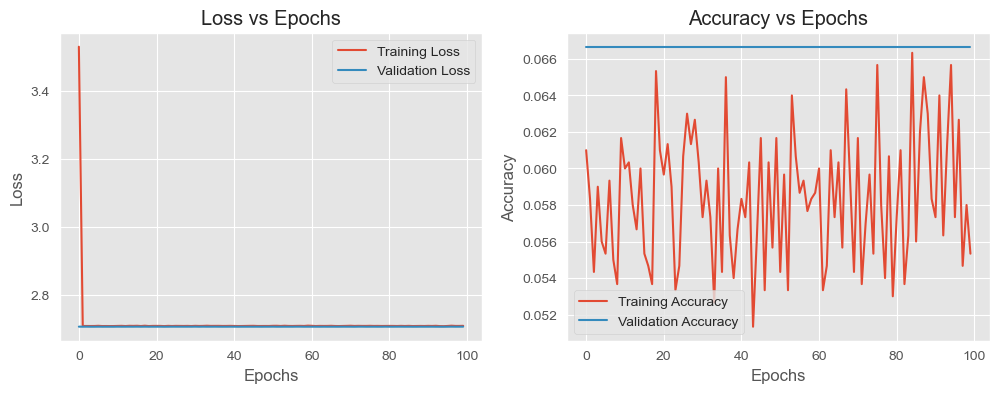

In [95]:
plot_graphs(history3)

In [96]:
test_loss3, test_accuracy3 = model3.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Test Loss: {test_loss3}, Test Accuracy: {test_accuracy3}")

24/24 [==============================] - 1s 32ms/step - loss: 2.7083 - accuracy: 0.0667
Test Loss: 2.7083089351654053, Test Accuracy: 0.06666667014360428


# Experiment with a learning rate of 0.01 and a batch size of 64

In [97]:
model4 = create_cnn_model((128, 128, 3),15,0.01)

In [98]:
history4 = model4.fit(np.array(train_images), np.array(train_labels_encoded),
                      epochs=100, batch_size=64, validation_data=(np.array(test_images), np.array(test_labels_encoded)))

Epoch 1/100
47/47 [==============================] - 10s 207ms/step - loss: 5.3320 - accuracy: 0.0600 - val_loss: 2.7085 - val_accuracy: 0.0667
Epoch 2/100
47/47 [==============================] - 9s 198ms/step - loss: 2.7100 - accuracy: 0.0620 - val_loss: 2.7082 - val_accuracy: 0.0667
Epoch 3/100
47/47 [==============================] - 9s 198ms/step - loss: 2.7094 - accuracy: 0.0577 - val_loss: 2.7082 - val_accuracy: 0.0667
Epoch 4/100
47/47 [==============================] - 9s 197ms/step - loss: 2.7099 - accuracy: 0.0567 - val_loss: 2.7082 - val_accuracy: 0.0667
Epoch 5/100
47/47 [==============================] - 9s 197ms/step - loss: 2.7096 - accuracy: 0.0603 - val_loss: 2.7081 - val_accuracy: 0.0667
Epoch 6/100
47/47 [==============================] - 9s 198ms/step - loss: 2.7097 - accuracy: 0.0607 - val_loss: 2.7081 - val_accuracy: 0.0667
Epoch 7/100
47/47 [==============================] - 9s 197ms/step - loss: 2.7095 - accuracy: 0.0587 - val_loss: 2.7081 - val_accuracy: 0.066

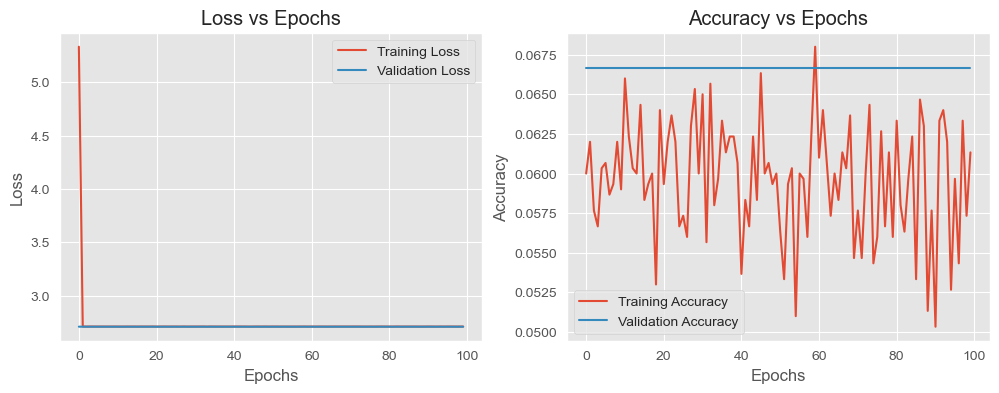

In [99]:
plot_graphs(history4)

In [100]:
test_loss4, test_accuracy4 = model4.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Test Loss: {test_loss4}, Test Accuracy: {test_accuracy4}")

24/24 [==============================] - 1s 30ms/step - loss: 2.7082 - accuracy: 0.0667
Test Loss: 2.7081515789031982, Test Accuracy: 0.06666667014360428


# Experiment with a learning rate of 0.0001 and a batch size of 64

In [33]:
model5 = create_cnn_model((128, 128, 3),15,0.0001)

In [34]:
history5 = model5.fit(np.array(train_images), np.array(train_labels_encoded),
                      epochs=40, batch_size=64, validation_data=(np.array(test_images), np.array(test_labels_encoded)))

Epoch 1/40
47/47 [==============================] - 12s 226ms/step - loss: 2.6874 - accuracy: 0.0970 - val_loss: 2.6306 - val_accuracy: 0.1173
Epoch 2/40
47/47 [==============================] - 13s 280ms/step - loss: 2.5232 - accuracy: 0.1760 - val_loss: 2.4115 - val_accuracy: 0.2227
Epoch 3/40
47/47 [==============================] - 17s 353ms/step - loss: 2.3008 - accuracy: 0.2313 - val_loss: 2.3061 - val_accuracy: 0.2413
Epoch 4/40
47/47 [==============================] - 16s 344ms/step - loss: 2.1365 - accuracy: 0.3130 - val_loss: 2.2222 - val_accuracy: 0.2533
Epoch 5/40
47/47 [==============================] - 16s 334ms/step - loss: 2.0354 - accuracy: 0.3303 - val_loss: 2.2641 - val_accuracy: 0.2600
Epoch 6/40
47/47 [==============================] - 12s 262ms/step - loss: 1.9790 - accuracy: 0.3473 - val_loss: 2.1617 - val_accuracy: 0.2773
Epoch 7/40
47/47 [==============================] - 10s 210ms/step - loss: 1.8835 - accuracy: 0.3903 - val_loss: 2.1650 - val_accuracy: 0.2840

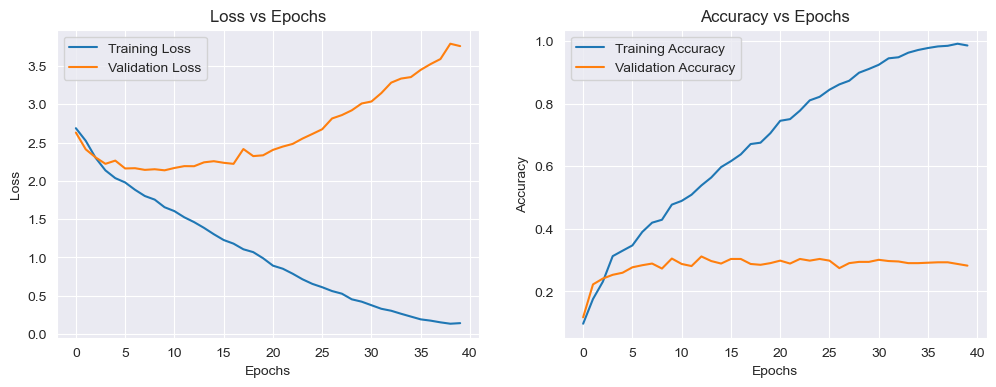

In [35]:
plot_graphs(history5)

In [36]:
test_loss5, test_accuracy5 = model5.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Test Loss: {test_loss5}, Test Accuracy: {test_accuracy5}")

24/24 [==============================] - 1s 31ms/step - loss: 3.7590 - accuracy: 0.2827
Test Loss: 3.7589635848999023, Test Accuracy: 0.2826666533946991


# Experiment with a learning rate of 0.001 and a batch size of 32

In [28]:
model6 = create_cnn_model((128, 128, 3),15,0.0001)

In [30]:
history6 = model6.fit(np.array(train_images), np.array(train_labels_encoded),
                      epochs=40, batch_size=32, validation_data=(np.array(test_images), np.array(test_labels_encoded)))

Epoch 1/40
94/94 [==============================] - 12s 123ms/step - loss: 2.6588 - accuracy: 0.1090 - val_loss: 2.6012 - val_accuracy: 0.1373
Epoch 2/40
94/94 [==============================] - 14s 146ms/step - loss: 2.4933 - accuracy: 0.1653 - val_loss: 2.4397 - val_accuracy: 0.1733
Epoch 3/40
94/94 [==============================] - 17s 186ms/step - loss: 2.3172 - accuracy: 0.2240 - val_loss: 2.3540 - val_accuracy: 0.2027
Epoch 4/40
94/94 [==============================] - 18s 190ms/step - loss: 2.2015 - accuracy: 0.2717 - val_loss: 2.3050 - val_accuracy: 0.2253
Epoch 5/40
94/94 [==============================] - 17s 185ms/step - loss: 2.1032 - accuracy: 0.3033 - val_loss: 2.2811 - val_accuracy: 0.2773
Epoch 6/40
94/94 [==============================] - 18s 195ms/step - loss: 2.0144 - accuracy: 0.3427 - val_loss: 2.2158 - val_accuracy: 0.2853
Epoch 7/40
94/94 [==============================] - 14s 146ms/step - loss: 1.9386 - accuracy: 0.3647 - val_loss: 2.2230 - val_accuracy: 0.2907

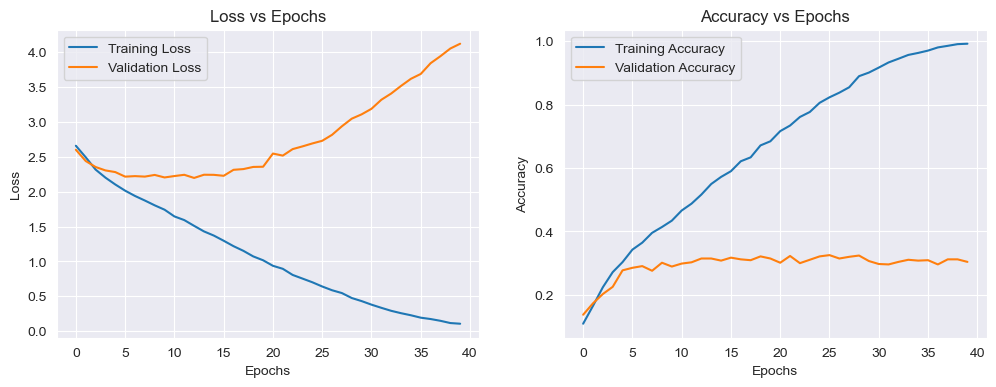

In [31]:
plot_graphs(history6)

In [32]:
test_loss6, test_accuracy6 = model6.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Test Loss: {test_loss6}, Test Accuracy: {test_accuracy6}")

24/24 [==============================] - 1s 55ms/step - loss: 4.1223 - accuracy: 0.3040
Test Loss: 4.122252464294434, Test Accuracy: 0.30399999022483826


# EXTRA ARCHITECTURE FOR COMPARISON 

In [5]:
def create_deep_cnn_model(input_shape=(128, 128, 3), num_classes=15, dropout_rate=0.5, learning_rate=0.001):
    """
    Creates a deep convolutional neural network (CNN) model for image classification.

    Parameters:
    - input_shape: Tuple representing the input shape of the images.
    - num_classes: Number of classes for classification.
    - dropout_rate: Dropout rate for regularization.
    - learning_rate: Learning rate for the Adam optimizer.

    Returns:
    - Compiled deep CNN model.
    """
    model = Sequential()

    # Convolutional Layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten Layer
    model.add(Flatten())

    # Fully Connected (Dense) Layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

In [6]:
model7 = create_deep_cnn_model((128, 128, 3),15,0.5,0.001)

In [9]:
history7 = model7.fit(np.array(train_images), np.array(train_labels_encoded),
                      epochs=50, batch_size=64, validation_data=(np.array(test_images), np.array(test_labels_encoded)))

Epoch 1/50
47/47 [==============================] - 11s 227ms/step - loss: 0.6875 - accuracy: 0.7607 - val_loss: 2.7090 - val_accuracy: 0.3427
Epoch 2/50
47/47 [==============================] - 10s 221ms/step - loss: 0.7093 - accuracy: 0.7553 - val_loss: 2.8008 - val_accuracy: 0.3333
Epoch 3/50
47/47 [==============================] - 10s 217ms/step - loss: 0.6205 - accuracy: 0.7987 - val_loss: 2.7703 - val_accuracy: 0.3373
Epoch 4/50
47/47 [==============================] - 10s 218ms/step - loss: 0.6187 - accuracy: 0.7883 - val_loss: 2.7884 - val_accuracy: 0.3107
Epoch 5/50
47/47 [==============================] - 11s 226ms/step - loss: 0.6177 - accuracy: 0.8003 - val_loss: 2.9049 - val_accuracy: 0.3213
Epoch 6/50
47/47 [==============================] - 11s 229ms/step - loss: 0.5628 - accuracy: 0.8113 - val_loss: 2.9385 - val_accuracy: 0.3413
Epoch 7/50
47/47 [==============================] - 11s 225ms/step - loss: 0.5356 - accuracy: 0.8253 - val_loss: 2.8985 - val_accuracy: 0.3427

In [10]:
test_loss7, test_accuracy7 = model7.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Test Loss: {test_loss7}, Test Accuracy: {test_accuracy7}")

24/24 [==============================] - 1s 32ms/step - loss: 3.3116 - accuracy: 0.3440
Test Loss: 3.3116331100463867, Test Accuracy: 0.3440000116825104


In [12]:
model8 = create_deep_cnn_model((128, 128, 3),15,0.5,0.001)

In [13]:
history8 = model8.fit(np.array(train_images), np.array(train_labels_encoded),
                      epochs=50, batch_size=32, validation_data=(np.array(test_images), np.array(test_labels_encoded)))

Epoch 1/50
94/94 [==============================] - 19s 192ms/step - loss: 2.7170 - accuracy: 0.0623 - val_loss: 2.7079 - val_accuracy: 0.0680
Epoch 2/50
94/94 [==============================] - 20s 218ms/step - loss: 2.6905 - accuracy: 0.0807 - val_loss: 2.6839 - val_accuracy: 0.1133
Epoch 3/50
94/94 [==============================] - 20s 217ms/step - loss: 2.6723 - accuracy: 0.0973 - val_loss: 2.6645 - val_accuracy: 0.1107
Epoch 4/50
94/94 [==============================] - 21s 219ms/step - loss: 2.6476 - accuracy: 0.1053 - val_loss: 2.6429 - val_accuracy: 0.1173
Epoch 5/50
94/94 [==============================] - 20s 217ms/step - loss: 2.6011 - accuracy: 0.1193 - val_loss: 2.5526 - val_accuracy: 0.1347
Epoch 6/50
94/94 [==============================] - 20s 216ms/step - loss: 2.5497 - accuracy: 0.1257 - val_loss: 2.5042 - val_accuracy: 0.1240
Epoch 7/50
94/94 [==============================] - 21s 220ms/step - loss: 2.5002 - accuracy: 0.1320 - val_loss: 2.4668 - val_accuracy: 0.1587

In [14]:
test_loss8, test_accuracy8 = model8.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Test Loss: {test_loss8}, Test Accuracy: {test_accuracy8}")

24/24 [==============================] - 1s 30ms/step - loss: 3.4818 - accuracy: 0.2800
Test Loss: 3.48179030418396, Test Accuracy: 0.2800000011920929


# Dropout Experiments

## Experiment with a dropout rate of 0.2

In [8]:
model9 = create_cnn_model_with_dropout((128, 128, 3), 15, 0.2, 0.001)

In [9]:
history9 = model9.fit(np.array(train_images), np.array(train_labels_encoded),
                      epochs=30, batch_size=64, validation_data=(np.array(test_images), np.array(test_labels_encoded)))

Epoch 1/30
47/47 [==============================] - 11s 217ms/step - loss: 2.6447 - accuracy: 0.0980 - val_loss: 2.6481 - val_accuracy: 0.1013
Epoch 2/30
47/47 [==============================] - 10s 210ms/step - loss: 2.3737 - accuracy: 0.1983 - val_loss: 2.2234 - val_accuracy: 0.2720
Epoch 3/30
47/47 [==============================] - 11s 233ms/step - loss: 2.1223 - accuracy: 0.2783 - val_loss: 2.1522 - val_accuracy: 0.2947
Epoch 4/30
47/47 [==============================] - 10s 214ms/step - loss: 1.9133 - accuracy: 0.3527 - val_loss: 2.0445 - val_accuracy: 0.3253
Epoch 5/30
47/47 [==============================] - 14s 294ms/step - loss: 1.6513 - accuracy: 0.4523 - val_loss: 2.0665 - val_accuracy: 0.3707
Epoch 6/30
47/47 [==============================] - 13s 282ms/step - loss: 1.3509 - accuracy: 0.5573 - val_loss: 2.1582 - val_accuracy: 0.3293
Epoch 7/30
47/47 [==============================] - 10s 211ms/step - loss: 1.0467 - accuracy: 0.6573 - val_loss: 2.2776 - val_accuracy: 0.3547

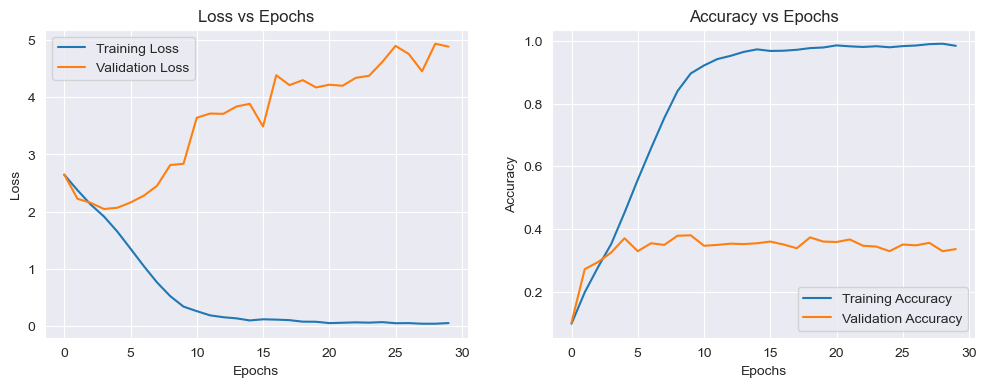

In [10]:
plot_graphs(history9)

In [11]:
test_loss9, test_accuracy9 = model9.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Test Loss: {test_loss9}, Test Accuracy: {test_accuracy9}")

24/24 [==============================] - 1s 30ms/step - loss: 4.8865 - accuracy: 0.3360
Test Loss: 4.88645601272583, Test Accuracy: 0.335999995470047


## Experiment with a dropout rate of 0.7

In [12]:
model10 = create_cnn_model_with_dropout((128, 128, 3), 15, 0.7, 0.001)

In [13]:
history10 = model10.fit(np.array(train_images), np.array(train_labels_encoded),
                      epochs=30, batch_size=64, validation_data=(np.array(test_images), np.array(test_labels_encoded)))

Epoch 1/30
47/47 [==============================] - 10s 202ms/step - loss: 2.7274 - accuracy: 0.0713 - val_loss: 2.6711 - val_accuracy: 0.0893
Epoch 2/30
47/47 [==============================] - 9s 195ms/step - loss: 2.6720 - accuracy: 0.0970 - val_loss: 2.6408 - val_accuracy: 0.1227
Epoch 3/30
47/47 [==============================] - 9s 195ms/step - loss: 2.6274 - accuracy: 0.1143 - val_loss: 2.5543 - val_accuracy: 0.1360
Epoch 4/30
47/47 [==============================] - 9s 195ms/step - loss: 2.5475 - accuracy: 0.1383 - val_loss: 2.4435 - val_accuracy: 0.1933
Epoch 5/30
47/47 [==============================] - 9s 195ms/step - loss: 2.4485 - accuracy: 0.1867 - val_loss: 2.3434 - val_accuracy: 0.2387
Epoch 6/30
47/47 [==============================] - 9s 196ms/step - loss: 2.2900 - accuracy: 0.2340 - val_loss: 2.2357 - val_accuracy: 0.2853
Epoch 7/30
47/47 [==============================] - 9s 196ms/step - loss: 2.1788 - accuracy: 0.2733 - val_loss: 2.1674 - val_accuracy: 0.2973
Epoch

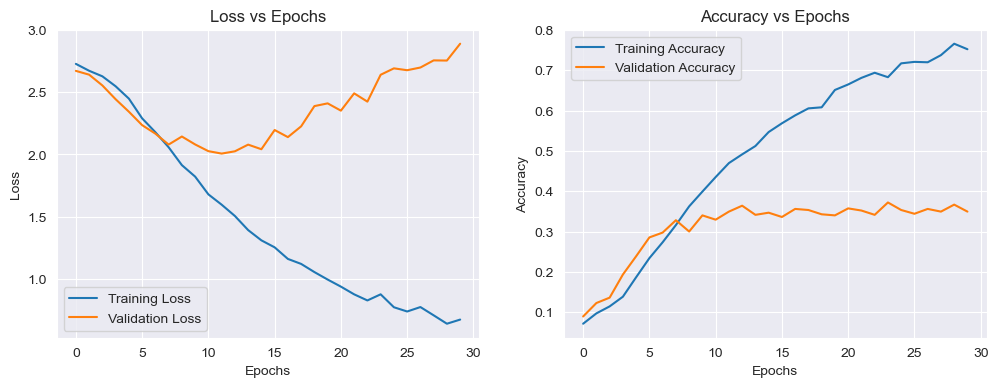

In [14]:
plot_graphs(history10)

In [15]:
test_loss10, test_accuracy10 = model10.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Test Loss: {test_loss10}, Test Accuracy: {test_accuracy10}")

24/24 [==============================] - 1s 30ms/step - loss: 2.8891 - accuracy: 0.3493
Test Loss: 2.889089584350586, Test Accuracy: 0.34933334589004517


## Experiment with a dropout rate of 0.8 

In [16]:
model11 = create_cnn_model_with_dropout((128, 128, 3), 15, 0.8, 0.001)

In [17]:
history11 = model11.fit(np.array(train_images), np.array(train_labels_encoded),
                      epochs=30, batch_size=64, validation_data=(np.array(test_images), np.array(test_labels_encoded)))

Epoch 1/30
47/47 [==============================] - 10s 200ms/step - loss: 2.7094 - accuracy: 0.0767 - val_loss: 2.6391 - val_accuracy: 0.1293
Epoch 2/30
47/47 [==============================] - 9s 194ms/step - loss: 2.6361 - accuracy: 0.0980 - val_loss: 2.5230 - val_accuracy: 0.1640
Epoch 3/30
47/47 [==============================] - 9s 194ms/step - loss: 2.5756 - accuracy: 0.1203 - val_loss: 2.4797 - val_accuracy: 0.1800
Epoch 4/30
47/47 [==============================] - 9s 194ms/step - loss: 2.5245 - accuracy: 0.1340 - val_loss: 2.4120 - val_accuracy: 0.2013
Epoch 5/30
47/47 [==============================] - 9s 195ms/step - loss: 2.4492 - accuracy: 0.1563 - val_loss: 2.3382 - val_accuracy: 0.2333
Epoch 6/30
47/47 [==============================] - 9s 193ms/step - loss: 2.4245 - accuracy: 0.1723 - val_loss: 2.2980 - val_accuracy: 0.2667
Epoch 7/30
47/47 [==============================] - 9s 195ms/step - loss: 2.3897 - accuracy: 0.1813 - val_loss: 2.2976 - val_accuracy: 0.2747
Epoch

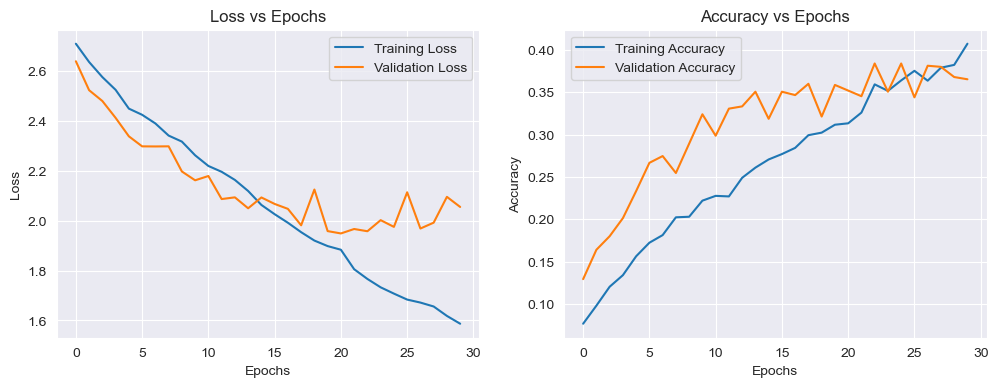

In [18]:
plot_graphs(history11)

In [19]:
test_loss11, test_accuracy11 = model11.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Test Loss: {test_loss11}, Test Accuracy: {test_accuracy11}")

24/24 [==============================] - 1s 30ms/step - loss: 2.0550 - accuracy: 0.3653
Test Loss: 2.0550084114074707, Test Accuracy: 0.36533331871032715


## Experiment with a dropout rate of 0.5

In [109]:
model12 = create_cnn_model_with_dropout((128, 128, 3), 15, 0.5, 0.001)

In [110]:
history12 = model12.fit(np.array(train_images), np.array(train_labels_encoded),
                        epochs=30, batch_size=64, validation_data=(np.array(test_images), np.array(test_labels_encoded)))

Epoch 1/30
47/47 [==============================] - 14s 224ms/step - loss: 2.6815 - accuracy: 0.1027 - val_loss: 2.5670 - val_accuracy: 0.1440
Epoch 2/30
47/47 [==============================] - 10s 213ms/step - loss: 2.5331 - accuracy: 0.1477 - val_loss: 2.4539 - val_accuracy: 0.1853
Epoch 3/30
47/47 [==============================] - 10s 214ms/step - loss: 2.3719 - accuracy: 0.2177 - val_loss: 2.3574 - val_accuracy: 0.2187
Epoch 4/30
47/47 [==============================] - 10s 206ms/step - loss: 2.2221 - accuracy: 0.2557 - val_loss: 2.1778 - val_accuracy: 0.2880
Epoch 5/30
47/47 [==============================] - 10s 209ms/step - loss: 2.1102 - accuracy: 0.3000 - val_loss: 2.1286 - val_accuracy: 0.3080
Epoch 6/30
47/47 [==============================] - 10s 206ms/step - loss: 1.9685 - accuracy: 0.3327 - val_loss: 2.0862 - val_accuracy: 0.2853
Epoch 7/30
47/47 [==============================] - 9s 201ms/step - loss: 1.7773 - accuracy: 0.4047 - val_loss: 2.0199 - val_accuracy: 0.3200


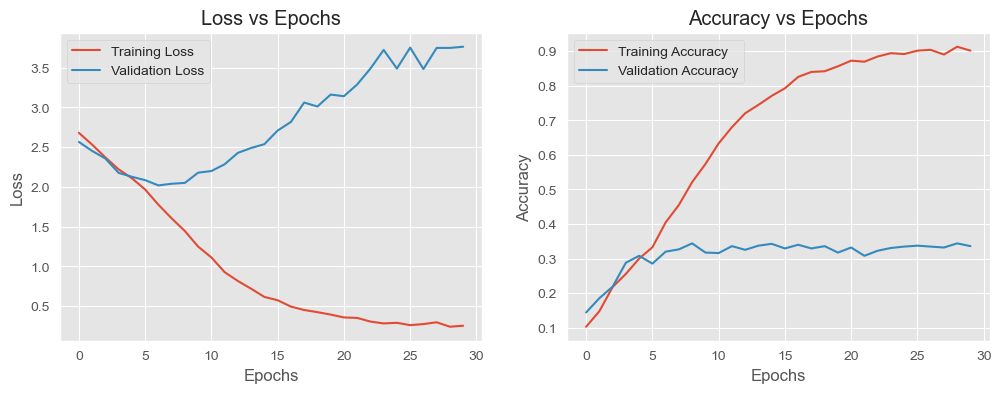

In [111]:
plot_graphs(history12)

In [112]:
test_loss12, test_accuracy12 = model12.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Test Loss: {test_loss12}, Test Accuracy: {test_accuracy12}")

24/24 [==============================] - 1s 31ms/step - loss: 3.7643 - accuracy: 0.3360
Test Loss: 3.7643206119537354, Test Accuracy: 0.335999995470047


# FINAL MODEL of PART 1

In [270]:
final_model = create_cnn_model_with_dropout((128, 128, 3), 15, 0.8, 0.001)

In [271]:
final_model_history = final_model.fit(np.array(train_images), np.array(train_labels_encoded),
                        epochs=30, batch_size=64, validation_data=(np.array(test_images), np.array(test_labels_encoded)))

Epoch 1/30
47/47 [==============================] - 12s 226ms/step - loss: 2.7656 - accuracy: 0.0720 - val_loss: 2.6870 - val_accuracy: 0.0840
Epoch 2/30
47/47 [==============================] - 10s 205ms/step - loss: 2.6804 - accuracy: 0.0907 - val_loss: 2.6291 - val_accuracy: 0.1213
Epoch 3/30
47/47 [==============================] - 10s 205ms/step - loss: 2.6606 - accuracy: 0.1100 - val_loss: 2.5865 - val_accuracy: 0.1347
Epoch 4/30
47/47 [==============================] - 10s 204ms/step - loss: 2.6157 - accuracy: 0.1207 - val_loss: 2.5471 - val_accuracy: 0.1520
Epoch 5/30
47/47 [==============================] - 10s 203ms/step - loss: 2.5628 - accuracy: 0.1333 - val_loss: 2.4462 - val_accuracy: 0.2040
Epoch 6/30
47/47 [==============================] - 10s 205ms/step - loss: 2.5166 - accuracy: 0.1467 - val_loss: 2.4573 - val_accuracy: 0.1533
Epoch 7/30
47/47 [==============================] - 10s 206ms/step - loss: 2.4907 - accuracy: 0.1537 - val_loss: 2.3612 - val_accuracy: 0.2467

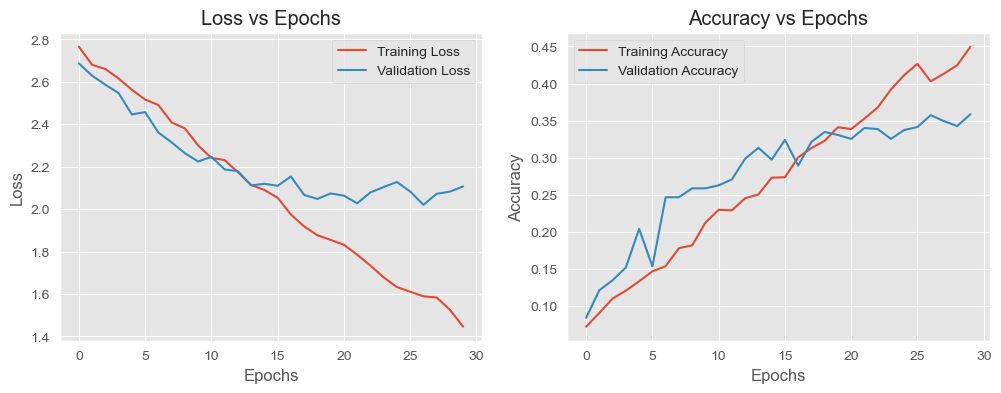

In [272]:
plot_graphs(final_model_history)

In [276]:
test_loss_final, test_accuracy_final = final_model.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Test Loss: {test_loss_final}, Test Accuracy: {test_accuracy_final}")

24/24 [==============================] - 1s 31ms/step - loss: 2.1069 - accuracy: 0.3587
Test Loss: 2.106882095336914, Test Accuracy: 0.35866665840148926


24/24 [==============================] - 1s 31ms/step


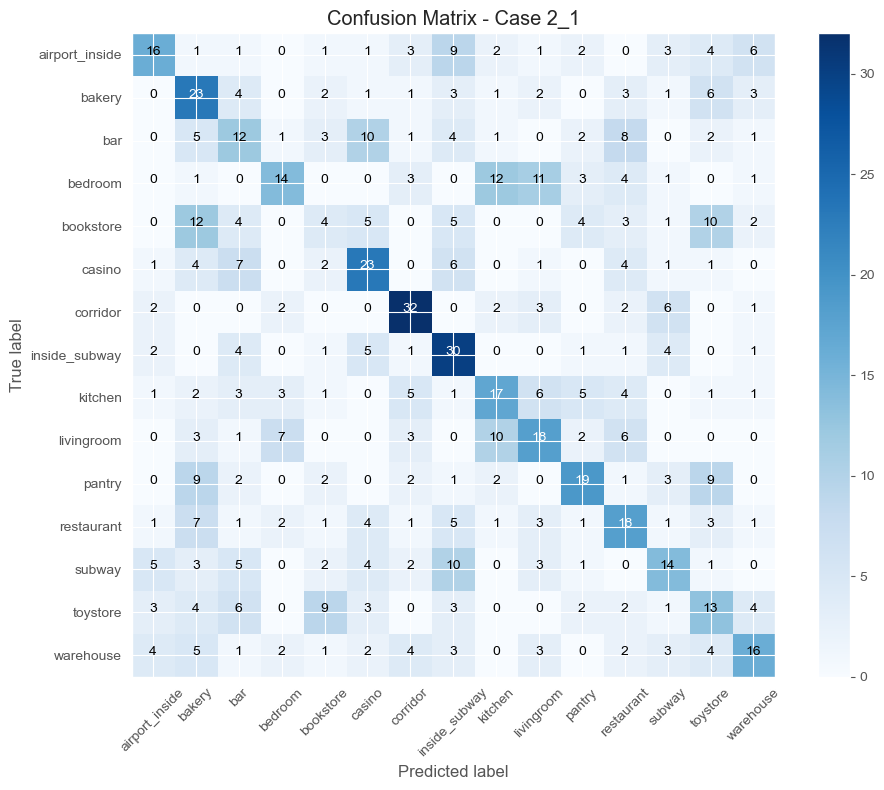

In [275]:
plot_confusion_matrix(final_model,test_images,test_labels_encoded)

# PART 2

A pre-trained VGG16 model is used as a base, with the option to freeze specific layers. Additional fully connected layers with ReLU activation and dropout are added on top of the base model, and the final model is constructed for fine-tuning. The number of trainable layers, input shape, number of classes, and dropout rate are configurable parameters. The function returns the fine-tuned model.

In [241]:
def create_fine_tuned_model(input_shape=(128, 128, 3), num_classes=15, trainable_layers=None, dropout_rate=0.5):
    """
    Creates a fine-tuned convolutional neural network (CNN) model based on the VGG16 architecture.

    Parameters:
    - input_shape: Tuple representing the input shape of the images.
    - num_classes: Number of classes for classification.
    - trainable_layers: Number of fully connected (FC) layers to unfreeze for fine-tuning. If None, all layers are frozen.
    - dropout_rate: Dropout rate for regularization.

    Returns:
    - Compiled fine-tuned CNN model.
    """
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze specified layers (FC layers)
    if trainable_layers is not None:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    print(model.summary())
    return model

# CASE 1 (train only FC layers and freeze rest)

In [15]:
model_case1_1 = create_fine_tuned_model(dropout_rate=0.5)
model_case1_1.compile(optimizer=Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [16]:
history_case1_1 = model_case1_1.fit(np.array(train_images), np.array(train_labels_encoded),
                                epochs=30, batch_size=64, validation_data=(np.array(validation_images), np.array(validation_labels_encoded)))

Epoch 1/30
47/47 [==============================] - 79s 2s/step - loss: 2.4981 - accuracy: 0.2080 - val_loss: 1.9191 - val_accuracy: 0.3907
Epoch 2/30
47/47 [==============================] - 79s 2s/step - loss: 1.8758 - accuracy: 0.3727 - val_loss: 1.5635 - val_accuracy: 0.5173
Epoch 3/30
47/47 [==============================] - 77s 2s/step - loss: 1.5959 - accuracy: 0.4627 - val_loss: 1.4047 - val_accuracy: 0.5533
Epoch 4/30
47/47 [==============================] - 76s 2s/step - loss: 1.4554 - accuracy: 0.5040 - val_loss: 1.3140 - val_accuracy: 0.5680
Epoch 5/30
47/47 [==============================] - 76s 2s/step - loss: 1.2600 - accuracy: 0.5667 - val_loss: 1.2904 - val_accuracy: 0.5947
Epoch 6/30
47/47 [==============================] - 75s 2s/step - loss: 1.1307 - accuracy: 0.6207 - val_loss: 1.2710 - val_accuracy: 0.5960
Epoch 7/30
47/47 [==============================] - 75s 2s/step - loss: 1.0417 - accuracy: 0.6497 - val_loss: 1.2178 - val_accuracy: 0.6000
Epoch 8/30
47/47 [==

In [17]:
test_loss_case1_1, test_accuracy_case1_1 = model_case1_1.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Case 1 Test Accuracy: {test_accuracy_case1_1}")

24/24 [==============================] - 16s 681ms/step - loss: 1.6313 - accuracy: 0.5987
Case 1 Test Accuracy: 0.5986666679382324


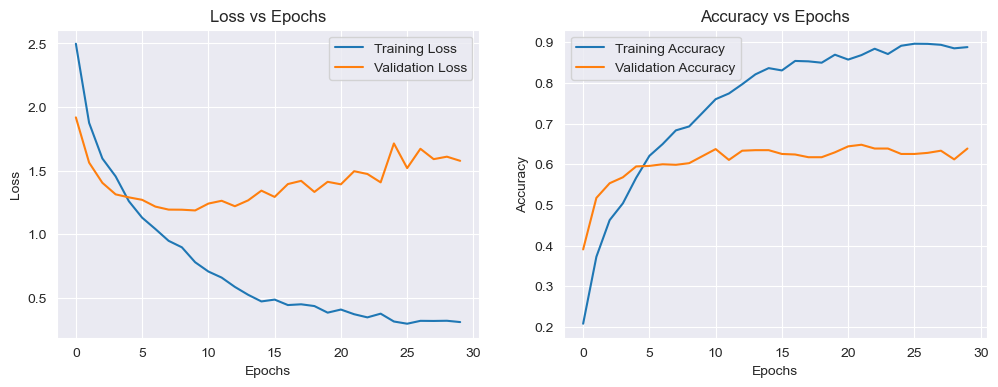

In [18]:
plot_graphs(history_case1_1)

# CASE 2 (train last two convolutional layers and FC layers and freeze rest)

In [23]:
model_case2 = create_fine_tuned_model(trainable_layers=2)
model_case2.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [24]:
history_case2 = model_case2.fit(np.array(train_images), np.array(train_labels_encoded),
                                epochs=30, batch_size=32, validation_data=(np.array(validation_images), np.array(validation_labels_encoded)))

Epoch 1/30
94/94 [==============================] - 87s 916ms/step - loss: 2.5452 - accuracy: 0.1933 - val_loss: 1.9700 - val_accuracy: 0.4427
Epoch 2/30
94/94 [==============================] - 117s 1s/step - loss: 1.9618 - accuracy: 0.3483 - val_loss: 1.5380 - val_accuracy: 0.5347
Epoch 3/30
94/94 [==============================] - 92s 982ms/step - loss: 1.5942 - accuracy: 0.4760 - val_loss: 1.3086 - val_accuracy: 0.5760
Epoch 4/30
94/94 [==============================] - 89s 947ms/step - loss: 1.3083 - accuracy: 0.5757 - val_loss: 1.1913 - val_accuracy: 0.6120
Epoch 5/30
94/94 [==============================] - 82s 879ms/step - loss: 1.0967 - accuracy: 0.6357 - val_loss: 1.1083 - val_accuracy: 0.6400
Epoch 6/30
94/94 [==============================] - 186s 2s/step - loss: 0.9163 - accuracy: 0.6990 - val_loss: 1.1056 - val_accuracy: 0.6413
Epoch 7/30
94/94 [==============================] - 80s 854ms/step - loss: 0.7396 - accuracy: 0.7550 - val_loss: 1.0369 - val_accuracy: 0.6587
Epo

In [25]:
test_loss_case2, test_accuracy_case2 = model_case2.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Case 2 Test Accuracy: {test_accuracy_case2}")

24/24 [==============================] - 27s 1s/step - loss: 1.6878 - accuracy: 0.6627
Case 2 Test Accuracy: 0.6626666784286499


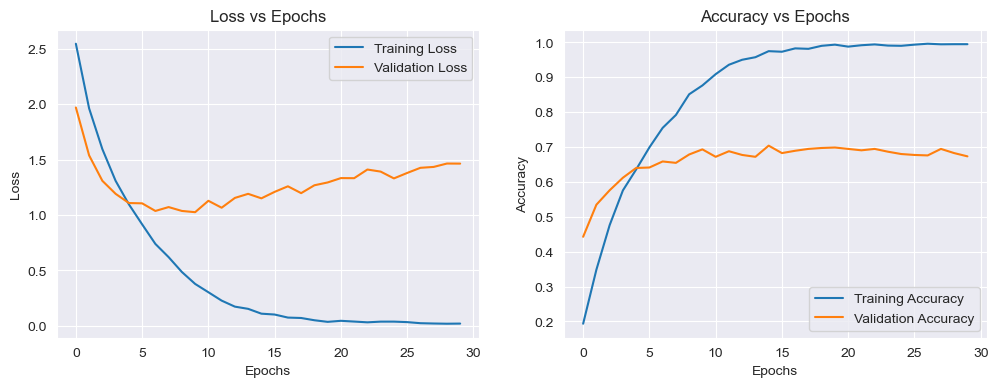

In [26]:
plot_graphs(history_case2)

# PART 2 EXPERIMENTS

## Experiment with a learning rate of 0.0001 and a batch size of 16

In [242]:
experiment1 = create_fine_tuned_model(trainable_layers=2)
experiment1.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

In [243]:
history_experiment1 = experiment1.fit(np.array(train_images), np.array(train_labels_encoded),
                                    epochs=30, batch_size=16, validation_data=(np.array(validation_images), np.array(validation_labels_encoded)))

Epoch 1/30
188/188 [==============================] - 92s 485ms/step - loss: 2.4802 - accuracy: 0.1947 - val_loss: 1.8376 - val_accuracy: 0.4480
Epoch 2/30
188/188 [==============================] - 86s 456ms/step - loss: 1.8103 - accuracy: 0.4080 - val_loss: 1.5075 - val_accuracy: 0.5320
Epoch 3/30
188/188 [==============================] - 85s 454ms/step - loss: 1.4655 - accuracy: 0.5117 - val_loss: 1.3351 - val_accuracy: 0.5520
Epoch 4/30
188/188 [==============================] - 85s 455ms/step - loss: 1.1851 - accuracy: 0.6093 - val_loss: 1.1762 - val_accuracy: 0.6200
Epoch 5/30
188/188 [==============================] - 85s 454ms/step - loss: 0.9579 - accuracy: 0.6893 - val_loss: 1.1163 - val_accuracy: 0.6213
Epoch 6/30
188/188 [==============================] - 85s 452ms/step - loss: 0.7649 - accuracy: 0.7620 - val_loss: 1.0762 - val_accuracy: 0.6387
Epoch 7/30
188/188 [==============================] - 85s 452ms/step - loss: 0.5765 - accuracy: 0.8140 - val_loss: 1.0973 - val_ac

In [244]:
test_loss_experiment1, test_accuracy_experiment1 = experiment1.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Case 2 Test Accuracy: {test_accuracy_experiment1}")

24/24 [==============================] - 16s 646ms/step - loss: 1.6105 - accuracy: 0.6867
Case 2 Test Accuracy: 0.6866666674613953


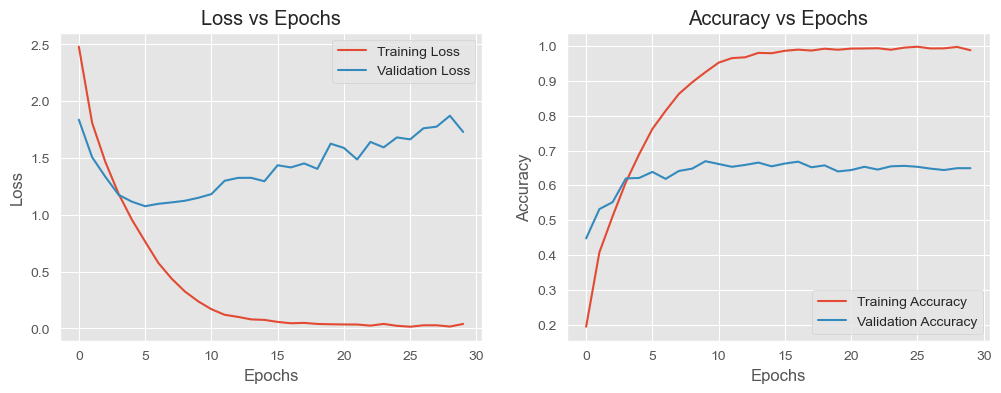

In [245]:
plot_graphs(history_experiment1)

## Experiment with a learning rate of 0.0002 and a batch size of 16

In [246]:
experiment2 = create_fine_tuned_model(trainable_layers=2)
experiment2.compile(optimizer=Adam(learning_rate=0.0002),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

In [247]:
history_experiment2 = experiment2.fit(np.array(train_images), np.array(train_labels_encoded),
                              epochs=30, batch_size=16, validation_data=(np.array(validation_images), np.array(validation_labels_encoded)))

Epoch 1/30
188/188 [==============================] - 87s 458ms/step - loss: 2.3449 - accuracy: 0.2387 - val_loss: 1.6853 - val_accuracy: 0.4547
Epoch 2/30
188/188 [==============================] - 86s 457ms/step - loss: 1.6752 - accuracy: 0.4530 - val_loss: 1.3400 - val_accuracy: 0.5627
Epoch 3/30
188/188 [==============================] - 86s 457ms/step - loss: 1.2779 - accuracy: 0.5647 - val_loss: 1.1534 - val_accuracy: 0.6253
Epoch 4/30
188/188 [==============================] - 86s 457ms/step - loss: 0.9925 - accuracy: 0.6710 - val_loss: 1.1115 - val_accuracy: 0.6227
Epoch 5/30
188/188 [==============================] - 86s 456ms/step - loss: 0.7521 - accuracy: 0.7470 - val_loss: 1.0827 - val_accuracy: 0.6320
Epoch 6/30
188/188 [==============================] - 86s 460ms/step - loss: 0.5443 - accuracy: 0.8247 - val_loss: 1.1280 - val_accuracy: 0.6453
Epoch 7/30
188/188 [==============================] - 86s 457ms/step - loss: 0.3853 - accuracy: 0.8750 - val_loss: 1.1658 - val_ac

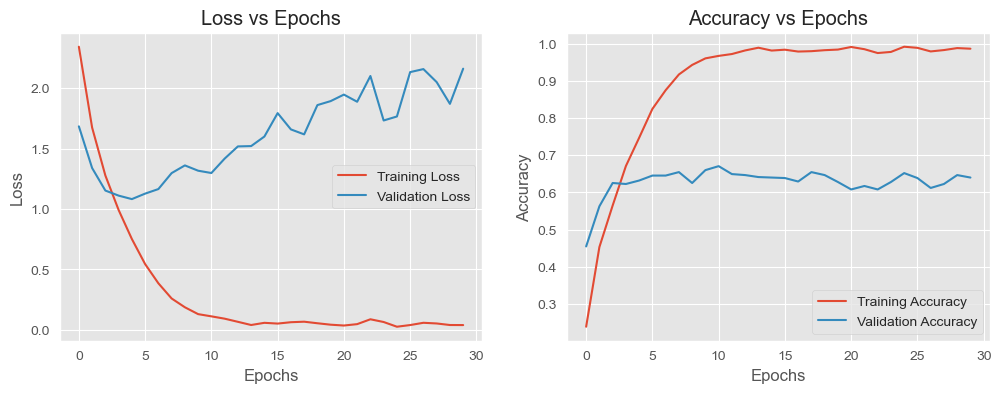

In [248]:
plot_graphs(history_experiment2)

In [261]:
test_loss_experiment2, test_accuracy_experiment2 = experiment2.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Case 2 Test Accuracy: {test_accuracy_experiment2}")

24/24 [==============================] - 19s 782ms/step - loss: 2.2114 - accuracy: 0.6653
Case 2 Test Accuracy: 0.6653333306312561


## Experiment with a learning rate of 0.0002 and a batch size of 32

In [249]:
experiment3 = create_fine_tuned_model(trainable_layers=2)
experiment3.compile(optimizer=Adam(learning_rate=0.0002),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

In [251]:
history_experiment3 = experiment3.fit(np.array(train_images), np.array(train_labels_encoded),
                              epochs=30, batch_size=32,
                              validation_data=(np.array(validation_images), np.array(validation_labels_encoded)))


Epoch 1/30
94/94 [==============================] - 81s 860ms/step - loss: 2.4838 - accuracy: 0.2093 - val_loss: 1.8811 - val_accuracy: 0.4133
Epoch 2/30
94/94 [==============================] - 80s 856ms/step - loss: 1.7808 - accuracy: 0.4097 - val_loss: 1.4276 - val_accuracy: 0.5480
Epoch 3/30
94/94 [==============================] - 80s 858ms/step - loss: 1.3998 - accuracy: 0.5380 - val_loss: 1.3192 - val_accuracy: 0.5573
Epoch 4/30
94/94 [==============================] - 80s 856ms/step - loss: 1.1092 - accuracy: 0.6273 - val_loss: 1.1441 - val_accuracy: 0.6133
Epoch 5/30
94/94 [==============================] - 80s 855ms/step - loss: 0.8688 - accuracy: 0.7147 - val_loss: 1.0621 - val_accuracy: 0.6613
Epoch 6/30
94/94 [==============================] - 80s 853ms/step - loss: 0.6464 - accuracy: 0.7827 - val_loss: 1.1085 - val_accuracy: 0.6493
Epoch 7/30
94/94 [==============================] - 80s 856ms/step - loss: 0.4896 - accuracy: 0.8420 - val_loss: 1.0589 - val_accuracy: 0.6613

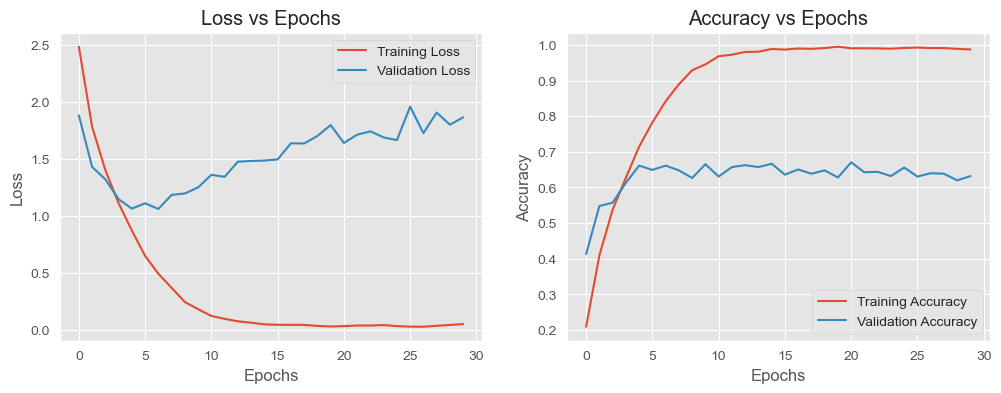

In [252]:
plot_graphs(history_experiment3)

In [262]:
test_loss_experiment3, test_accuracy_experiment3 = experiment3.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Case 2 Test Accuracy: {test_accuracy_experiment3}")

24/24 [==============================] - 20s 799ms/step - loss: 1.8097 - accuracy: 0.6573
Case 2 Test Accuracy: 0.6573333144187927


## Experiment with a learning rate of 0.001 and a batch size of 16

In [253]:
experiment4 = create_fine_tuned_model(trainable_layers=2)
experiment4.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

In [255]:
history_experiment4 = experiment4.fit(np.array(train_images), np.array(train_labels_encoded),
                              epochs=30, batch_size=16,
                              validation_data=(np.array(validation_images), np.array(validation_labels_encoded)))

Epoch 1/30
188/188 [==============================] - 88s 457ms/step - loss: 2.2397 - accuracy: 0.2680 - val_loss: 1.6969 - val_accuracy: 0.4253
Epoch 2/30
188/188 [==============================] - 85s 451ms/step - loss: 1.6795 - accuracy: 0.4520 - val_loss: 1.7353 - val_accuracy: 0.4360
Epoch 3/30
188/188 [==============================] - 85s 451ms/step - loss: 1.3396 - accuracy: 0.5607 - val_loss: 1.3819 - val_accuracy: 0.5640
Epoch 4/30
188/188 [==============================] - 85s 452ms/step - loss: 1.0744 - accuracy: 0.6443 - val_loss: 1.4625 - val_accuracy: 0.5600
Epoch 5/30
188/188 [==============================] - 86s 457ms/step - loss: 0.9079 - accuracy: 0.7010 - val_loss: 1.4077 - val_accuracy: 0.5387
Epoch 6/30
188/188 [==============================] - 85s 455ms/step - loss: 0.7436 - accuracy: 0.7570 - val_loss: 1.4499 - val_accuracy: 0.5907
Epoch 7/30
188/188 [==============================] - 85s 452ms/step - loss: 0.6158 - accuracy: 0.7970 - val_loss: 1.7738 - val_ac

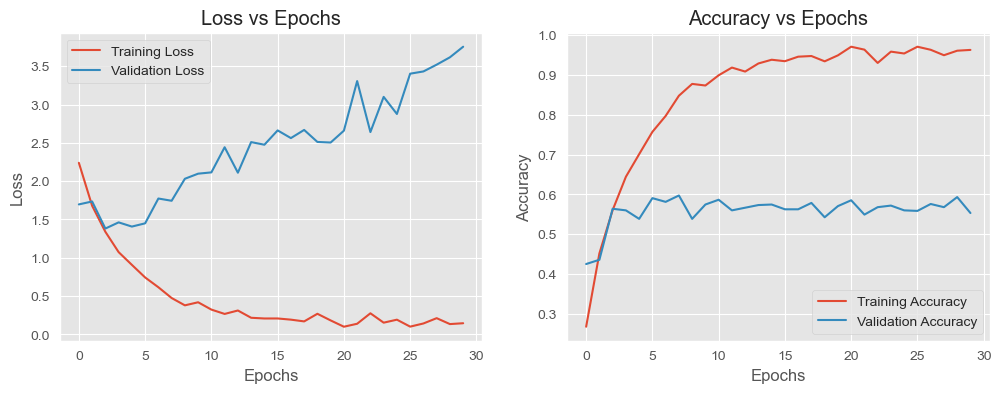

In [256]:
plot_graphs(history_experiment4)

In [263]:
test_loss_experiment4, test_accuracy_experiment4 = experiment4.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Case 2 Test Accuracy: {test_accuracy_experiment4}")

24/24 [==============================] - 19s 783ms/step - loss: 3.3868 - accuracy: 0.5773
Case 2 Test Accuracy: 0.5773333311080933


## Experiment with a learning rate of 0.001 and a batch size of 32

In [257]:
experiment5 = create_fine_tuned_model(trainable_layers=2)
experiment5.compile(optimizer=Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

In [259]:
history_experiment5 = experiment5.fit(np.array(train_images), np.array(train_labels_encoded),
                              epochs=30, batch_size=32,
                              validation_data=(np.array(validation_images), np.array(validation_labels_encoded)))

Epoch 1/30
94/94 [==============================] - 81s 853ms/step - loss: 2.2750 - accuracy: 0.2570 - val_loss: 1.6713 - val_accuracy: 0.4147
Epoch 2/30
94/94 [==============================] - 79s 844ms/step - loss: 1.6161 - accuracy: 0.4640 - val_loss: 1.3628 - val_accuracy: 0.5680
Epoch 3/30
94/94 [==============================] - 79s 847ms/step - loss: 1.2764 - accuracy: 0.5790 - val_loss: 1.3476 - val_accuracy: 0.5707
Epoch 4/30
94/94 [==============================] - 79s 842ms/step - loss: 1.0154 - accuracy: 0.6673 - val_loss: 1.2824 - val_accuracy: 0.5933
Epoch 5/30
94/94 [==============================] - 79s 843ms/step - loss: 0.7660 - accuracy: 0.7453 - val_loss: 1.4078 - val_accuracy: 0.6133
Epoch 6/30
94/94 [==============================] - 79s 843ms/step - loss: 0.6734 - accuracy: 0.7770 - val_loss: 1.3515 - val_accuracy: 0.6293
Epoch 7/30
94/94 [==============================] - 79s 842ms/step - loss: 0.5476 - accuracy: 0.8223 - val_loss: 1.4054 - val_accuracy: 0.6173

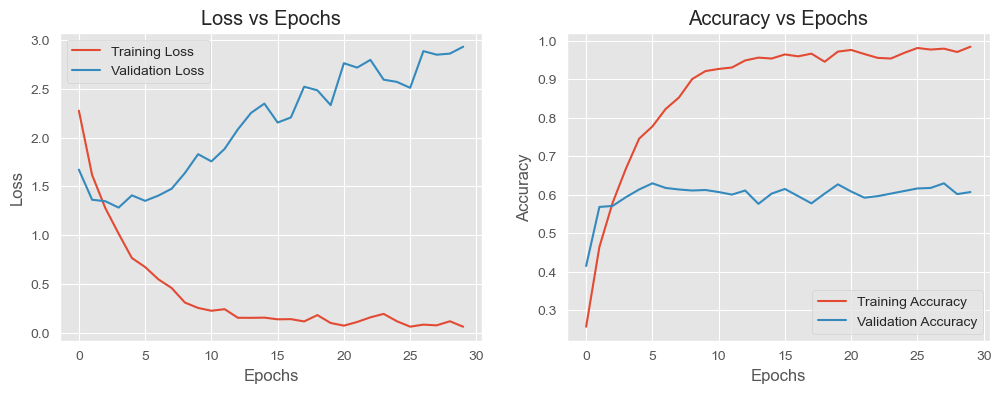

In [260]:
plot_graphs(history_experiment5)

In [264]:
test_loss_experiment5, test_accuracy_experiment5 = experiment5.evaluate(np.array(test_images), np.array(test_labels_encoded))
print(f"Case 2 Test Accuracy: {test_accuracy_experiment5}")

24/24 [==============================] - 23s 914ms/step - loss: 2.7969 - accuracy: 0.6227
Case 2 Test Accuracy: 0.6226666569709778


# FINAL Model

In [277]:
final_experiment = create_fine_tuned_model(trainable_layers=2,dropout_rate=0.7)
final_experiment.compile(optimizer=Adam(learning_rate=0.0001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

In [278]:
history_final_experiment = final_experiment.fit(np.array(train_images), np.array(train_labels_encoded),
                                      epochs=30, batch_size=16, validation_data=(
        np.array(validation_images), np.array(validation_labels_encoded)))

Epoch 1/30
188/188 [==============================] - 98s 515ms/step - loss: 2.8526 - accuracy: 0.0857 - val_loss: 2.5710 - val_accuracy: 0.2893
Epoch 2/30
188/188 [==============================] - 103s 547ms/step - loss: 2.5732 - accuracy: 0.1500 - val_loss: 2.2907 - val_accuracy: 0.3973
Epoch 3/30
188/188 [==============================] - 93s 496ms/step - loss: 2.3439 - accuracy: 0.2420 - val_loss: 1.9601 - val_accuracy: 0.4293
Epoch 4/30
188/188 [==============================] - 114s 609ms/step - loss: 2.0903 - accuracy: 0.3280 - val_loss: 1.7024 - val_accuracy: 0.4893
Epoch 5/30
188/188 [==============================] - 107s 572ms/step - loss: 1.8606 - accuracy: 0.3840 - val_loss: 1.5538 - val_accuracy: 0.5027
Epoch 6/30
188/188 [==============================] - 86s 459ms/step - loss: 1.6965 - accuracy: 0.4410 - val_loss: 1.4141 - val_accuracy: 0.5440
Epoch 7/30
188/188 [==============================] - 86s 456ms/step - loss: 1.5161 - accuracy: 0.5077 - val_loss: 1.3298 - val

In [279]:
test_loss_final_experiment, test_accuracy_final_experiment = final_experiment.evaluate(np.array(test_images),
                                                                        np.array(test_labels_encoded))
print(f"Final Model Test Accuracy: {test_accuracy_final_experiment}")

24/24 [==============================] - 16s 660ms/step - loss: 1.4398 - accuracy: 0.6907
Final Model Test Accuracy: 0.690666675567627


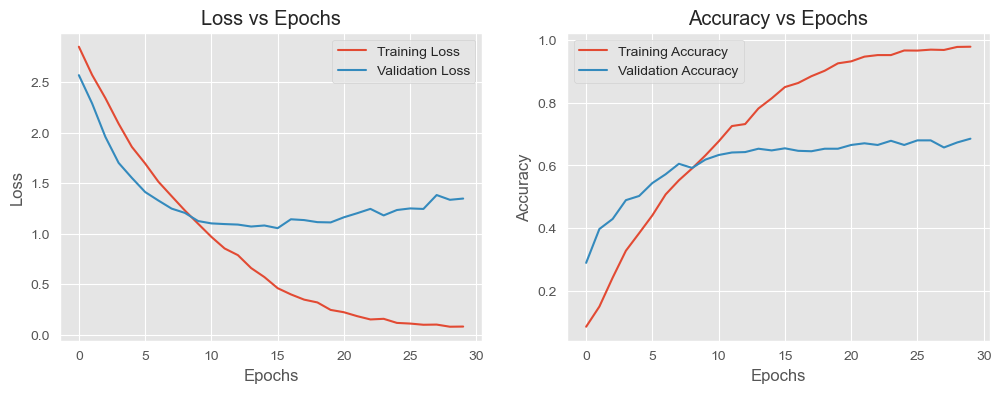

In [281]:
plot_graphs(history_final_experiment)

24/24 [==============================] - 16s 662ms/step


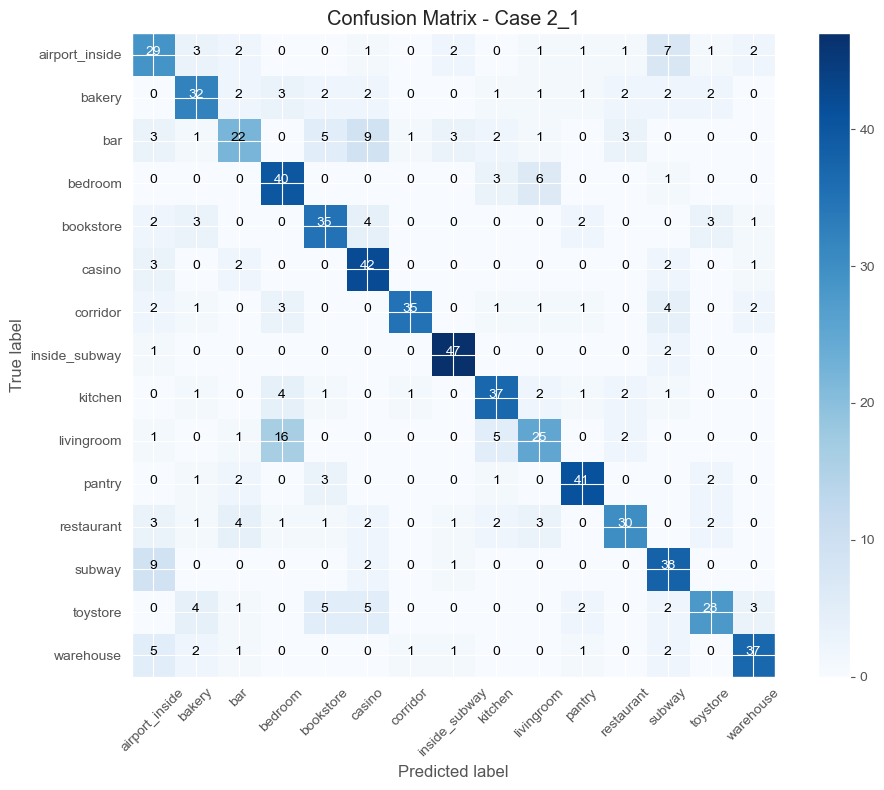

In [280]:
plot_confusion_matrix(final_experiment,test_images, test_labels_encoded)

# PART 3

Training and validation losses, as well as accuracies, are plotted using a ggplot style. A subplot grid is created for the specified loss names, and each loss is visualized with respect to epochs. The accuracies for class labels are separately displayed in a distinct subplot. The resulting plots are then shown.

In [2]:
def plot_losses_and_accuracies(history, loss_names):
    """
    Plots training and validation losses and accuracies.

    Parameters:
    - history: History object returned by the model.fit() function.
    - loss_names: List of loss names to plot.
    - save_path: Optional path to save the plot as an image.
    """
    plt.style.use("ggplot")

    # Create subplot grid for losses
    fig, axes = plt.subplots(1, len(loss_names), figsize=(15, 5))

    for (i, loss_name) in enumerate(loss_names):
        title = "Loss for {}".format(loss_name) if loss_name != "loss" else "Total loss"
        axes[i].set_title(title)
        axes[i].set_xlabel("Epoch #")
        axes[i].set_ylabel("Loss")
        axes[i].plot(np.arange(0, len(history.history[loss_name])), history.history[loss_name], label=loss_name)
        axes[i].plot(np.arange(0, len(history.history[loss_name])), history.history["val_" + loss_name], label="val_" + loss_name)
        axes[i].legend()

    plt.tight_layout()

    # Create a separate subplot for accuracies
    plt.figure(figsize=(10, 8))
    plt.plot(np.arange(0, len(history.history["bounding_box_accuracy"])), history.history["bounding_box_accuracy"], label="bounding_box_train_acc")
    plt.plot(np.arange(0, len(history.history["val_bounding_box_accuracy"])), history.history["val_bounding_box_accuracy"], label="val_bounding_box_acc")
    plt.title("Class Label Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")

    plt.show()

The function preprocess_and_bundle_data normalizes image data, organizes labels, bounding boxes, and file paths, returning the results as normalized_images, organized_labels, normalized_bounding_boxes, and organized_paths, respectively.

In [3]:
def preprocess_and_bundle_data(images, labels, bounding_boxes, paths):
    """
    Normalizes image data, organizes labels, bounding boxes, and file paths.
    
    Parameters:
    - images: Image data in float32 format.
    - labels: Labels of the images.
    - bounding_boxes: Bounding boxes associated with the images.
    - paths: File paths of the images.
    
    Returns:
    - Normalized image data, labels, bounding boxes, and file paths.
    """
    normalized_images = np.array(images, dtype="float32") / 255.0
    organized_labels = np.array(labels)
    normalized_bounding_boxes = np.array(bounding_boxes, dtype="float32")
    organized_paths = np.array(paths)

    return normalized_images, organized_labels, normalized_bounding_boxes, organized_paths

The raccoon dataset is loaded for a specified split ('train' or 'test') from the given directory path. The function reads annotations from an annotations file, processes the images, and extracts bounding box coordinates. The resulting preprocessed data, labels, bounding boxes, and image paths are returned as a tuple.

In [4]:
def load_raccoon_dataset(split, dataset_dir):
    """
    Loads the raccoon dataset for a specified split (e.g., 'train', 'test').

    Parameters:
    - split: Split of the dataset ('train', 'test').
    - dataset_dir: Directory path containing the dataset.

    Returns:
    - Tuple containing preprocessed data, labels, bounding boxes, and image paths.
    """
    data = []
    labels = []
    bboxes = []
    imagePaths = []

    annotations_file = f'{dataset_dir}/{split}/_annotations.txt'

    # Read the annotations from the annotations file
    with open(annotations_file, 'r') as annotations_file:
        lines = annotations_file.read().splitlines()


    for line in lines:
        parts = line.split()
        image_path = f'{dataset_dir}/{split}/{parts[0]}'
        image = cv2.imread(image_path)
        (h, w) = image.shape[:2]


        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)


        if len(parts[1:]) >= 1:
            all_coordinates = parts[1:]

        for coord in all_coordinates:
            coordinates = coord.split(",")

            Xmin = float(coordinates[0]) / w
            Ymin = float(coordinates[1]) / h
            Xmax = float(coordinates[2]) / w
            Ymax = float(coordinates[3]) / h

            bboxes.append((Xmin, Ymin, Xmax, Ymax))
            data.append(image)
            labels.append(0)
            imagePaths.append(image_path)
 
    data, labels,bboxes,imagePaths = preprocess_and_bundle_data(data, labels,bboxes,imagePaths)

    return data, labels,bboxes,imagePaths

The raccoon dataset is loaded for training, testing, and validation splits from the 'raccoon_dataset' directory. The resulting data, labels, bounding boxes, and image paths are assigned to corresponding variables for each split: train_data, train_labels, train_bboxes, train_imagePaths for training, test_data, test_labels, test_bboxes, test_imagePaths for testing, and validation_data, validation_labels, validation_bboxes, validation_imagePaths for validation.

In [5]:
dataset_dir = 'raccoon_dataset'
train_data, train_labels, train_bboxes, train_imagePaths = load_raccoon_dataset('train', dataset_dir)
test_data, test_labels, test_bboxes, test_imagePaths  = load_raccoon_dataset('test', dataset_dir)
validation_data, validation_labels, validation_bboxes, validation_imagePaths = load_raccoon_dataset('valid', dataset_dir)

The pre-trained VGG16 model, excluding its fully connected layers, is loaded with ImageNet weights. The weights of the VGG16 model are frozen to prevent further training. The output is flattened, and two separate branches are added for coordinates prediction (regression) and class prediction (classification). The coordinates prediction branch consists of three dense layers with ReLU activation followed by a dense layer with sigmoid activation. The class prediction branch involves multiple dense layers with ReLU activation, interspersed with dropout layers for regularization, and ends with a dense layer with softmax activation for class labels.

In [35]:
# Load the VGG16 model pre-trained on ImageNet, excluding the fully connected layers
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the weights of the pre-trained VGG16 model to prevent training
vgg.trainable = False

# Flatten the output of the VGG16 model
flatten = vgg.output
flatten = Flatten()(flatten)

# For coordinates prediction (regression)
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# For class prediction (classification)
softmaxHead = Dense(128, activation="relu")(flatten)
softmaxHead = Dropout(0.2)(softmaxHead)
softmaxHead = Dense(1, activation="softmax", name="class_label")(softmaxHead)

The model takes VGG16 as input and outputs both bounding box coordinates (bboxHead) and class labels (softmaxHead).

In [36]:
model = Model(
    inputs=vgg.input,
    outputs=(bboxHead, softmaxHead))

Loss functions are defined for the class label prediction as binary cross-entropy and for the bounding box prediction as mean squared error.

In [37]:
losses = {
    "class_label": "binary_crossentropy",
    "bounding_box": "mean_squared_error",
}

In [38]:
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

Training targets include both class labels (class_label) and bounding box coordinates (bounding_box) for the training set. Similarly, test and validation targets are defined accordingly with class labels and bounding box coordinates.

In [39]:
trainTargets = {
    "class_label": train_labels,
    "bounding_box": train_bboxes
}

In [40]:
testTargets = {
    "class_label": test_labels,
    "bounding_box": test_bboxes
}

In [41]:
validationTargets = {
    "class_label": validation_labels,
    "bounding_box": validation_bboxes
}

The model is compiled using the Adam optimizer with a learning rate of 1e-4. The losses include binary cross-entropy for class label prediction and mean squared error for bounding box prediction, with equal weight assigned to both losses

In [42]:
optimizer = Adam(1e-4)

model.compile(loss=losses,
              optimizer=optimizer,
              metrics=["accuracy"],
              loss_weights=lossWeights)

print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

The model is trained using the fit method for 30 epochs, with a batch size of 32. The training data and targets are provided, and validation data along with its targets are used for validation during training. The verbosity level is set to 1 for progress updates.

In [43]:
history = model.fit(
    train_data, trainTargets,
    validation_data=(validation_data, validationTargets),
    batch_size=32,
    epochs=30,
    verbose=1)

Epoch 1/30
6/6 [==============================] - 15s 2s/step - loss: 0.2708 - bounding_box_loss: 0.0613 - class_label_loss: 0.2096 - bounding_box_accuracy: 0.6159 - class_label_accuracy: 0.0000e+00 - val_loss: 0.0104 - val_bounding_box_loss: 0.0103 - val_class_label_loss: 1.0396e-04 - val_bounding_box_accuracy: 0.6207 - val_class_label_accuracy: 0.0000e+00
Epoch 2/30
6/6 [==============================] - 12s 2s/step - loss: 0.0251 - bounding_box_loss: 0.0250 - class_label_loss: 8.3393e-05 - bounding_box_accuracy: 0.7195 - class_label_accuracy: 0.0000e+00 - val_loss: 0.0099 - val_bounding_box_loss: 0.0099 - val_class_label_loss: 2.3788e-06 - val_bounding_box_accuracy: 0.6207 - val_class_label_accuracy: 0.0000e+00
Epoch 3/30
6/6 [==============================] - 12s 2s/step - loss: 0.0225 - bounding_box_loss: 0.0224 - class_label_loss: 5.1199e-06 - bounding_box_accuracy: 0.7195 - class_label_accuracy: 0.0000e+00 - val_loss: 0.0117 - val_bounding_box_loss: 0.0117 - val_class_label_loss

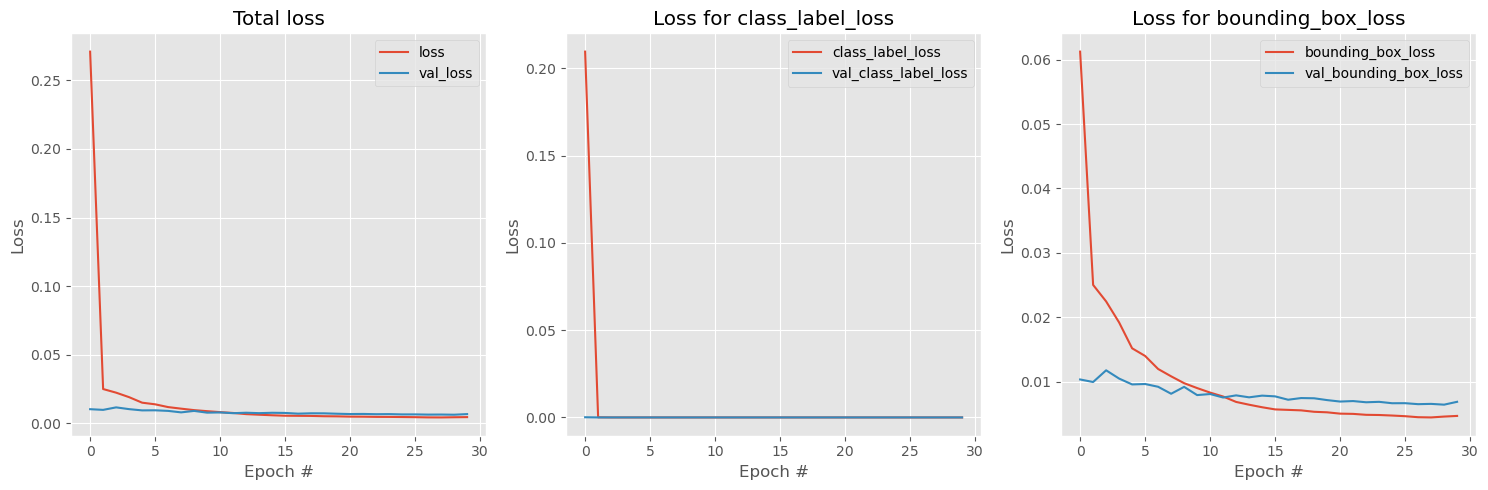

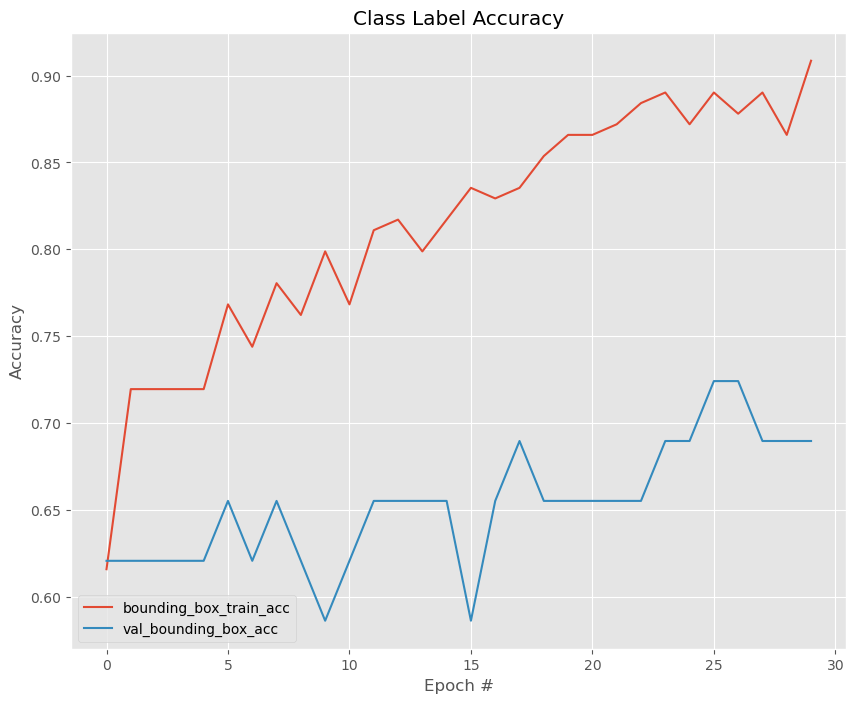

In [44]:
loss_names = ["loss", "class_label_loss", "bounding_box_loss"]
plot_losses_and_accuracies(history,loss_names)

This function is utilized to assess the performance of a model on test data by calculating the Mean Intersection over Union (mIoU) and classification accuracy.

In [45]:
def report_results(model,test_labels,test_targets):
    """
    Reports and prints the Mean Intersection over Union (mIoU) and classification accuracy for a given model 
    using the test data and labels.

    Parameters:
    - model: The trained model to evaluate.
    - test_labels: True class labels for the test data.

    Returns:
    None
    """
    test_predictions = model.predict(test_data)
    test_bboxes_gt = test_targets["bounding_box"]
    
    # Extract predicted class labels and bounding boxes
    test_labels_pred = np.argmax(test_predictions[1], axis=1)
    test_bboxes_pred = test_predictions[0]
    
    # Calculate MIoU
    intersection = np.sum(np.minimum(test_bboxes_gt, test_bboxes_pred), axis=1)
    union = np.sum(np.maximum(test_bboxes_gt, test_bboxes_pred), axis=1)
    iou = intersection / union
    mIoU = np.mean(iou)
    print("mIoU:", mIoU)
    
    # Calculate Accuracy
    accuracy = accuracy_score(test_labels, test_labels_pred)
    print("Accuracy:", accuracy)

In [46]:
report_results(model,test_labels,testTargets)

1/1 [==============================] - 1s 1s/step
mIoU: 0.8537
Accuracy: 1.0


# Try different hyperparameters (learning rate, batch size) 

In [47]:
model2 = Model(
    inputs=vgg.input,
    outputs=(bboxHead, softmaxHead))

In [48]:
optimizer = Adam(1e-3)

model2.compile(loss=losses,
              optimizer=optimizer,
              metrics=["accuracy"],
              loss_weights=lossWeights)

print(model2.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_5[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [69]:
history2 = model2.fit(
    train_data, trainTargets,
    validation_data=(validation_data, validationTargets),
    batch_size=16,
    epochs=30,
    verbose=1)

Epoch 1/30
11/11 [==============================] - 16s 1s/step - loss: 0.0389 - bounding_box_loss: 0.0389 - class_label_loss: 4.5895e-08 - bounding_box_accuracy: 0.6829 - class_label_accuracy: 0.0000e+00 - val_loss: 0.0161 - val_bounding_box_loss: 0.0161 - val_class_label_loss: 1.5408e-09 - val_bounding_box_accuracy: 0.6207 - val_class_label_accuracy: 0.0000e+00
Epoch 2/30
11/11 [==============================] - 20s 2s/step - loss: 0.0365 - bounding_box_loss: 0.0365 - class_label_loss: 9.8014e-09 - bounding_box_accuracy: 0.7195 - class_label_accuracy: 0.0000e+00 - val_loss: 0.0260 - val_bounding_box_loss: 0.0260 - val_class_label_loss: 3.6803e-10 - val_bounding_box_accuracy: 0.6207 - val_class_label_accuracy: 0.0000e+00
Epoch 3/30
11/11 [==============================] - 14s 1s/step - loss: 0.0424 - bounding_box_loss: 0.0424 - class_label_loss: 1.8992e-09 - bounding_box_accuracy: 0.7195 - class_label_accuracy: 0.0000e+00 - val_loss: 0.0154 - val_bounding_box_loss: 0.0154 - val_class_

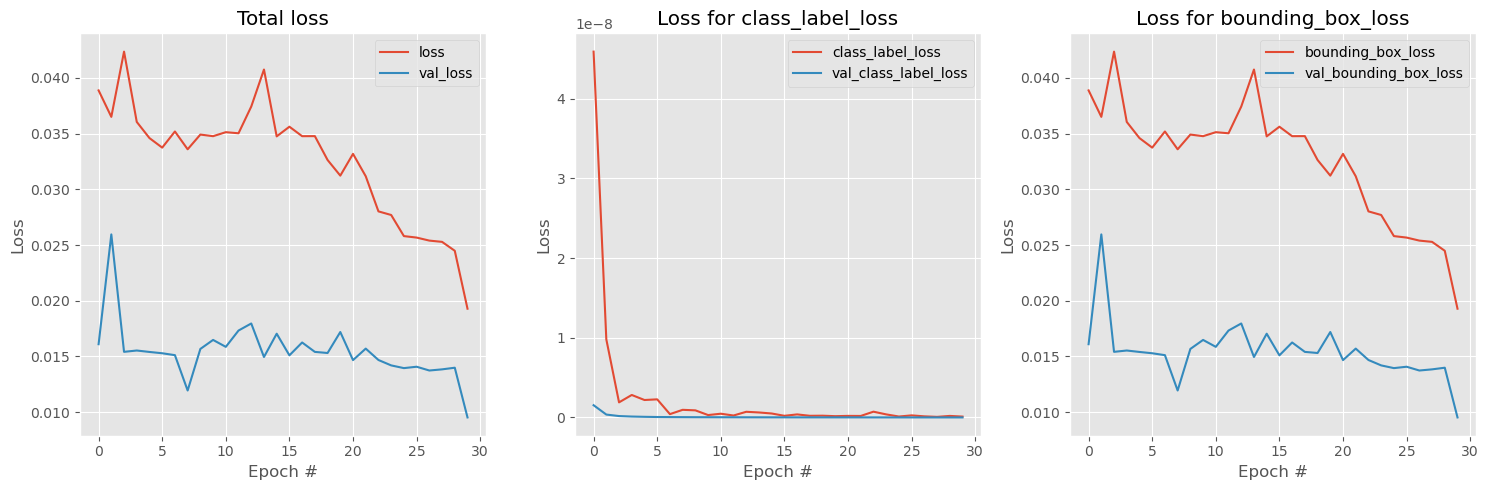

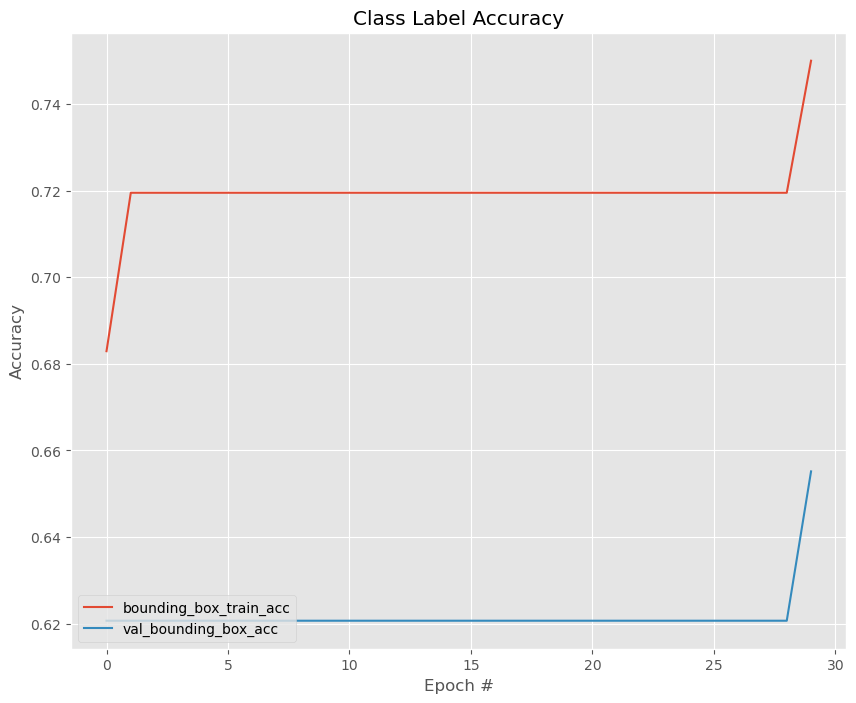

In [72]:
plot_losses_and_accuracies(history2,loss_names)

In [73]:
report_results(model2,test_labels,testTargets)

1/1 [==============================] - 1s 1s/step
mIoU: 0.81875145
Accuracy: 1.0


## Testing and Visiualization of Final Results

In this following code, the model is used to predict class labels and bounding box coordinates for images in the test set. The predictions are then visualized by drawing bounding boxes on the images, with predicted bounding boxes in green and ground truth bounding boxes in red. The images are displayed sequentially with their corresponding predictions.

In [66]:
def scale_and_draw_bounding_box(input_image, relative_start_x, relative_start_y, relative_end_x, relative_end_y, box_color):
    (height, width) = input_image.shape[:2]
    absolute_start_x = int(relative_start_x * width)
    absolute_start_y = int(relative_start_y * height)
    absolute_end_x = int(relative_end_x * width)
    absolute_end_y = int(relative_end_y * height)

    draw_rectangular_box(input_image, absolute_start_x, absolute_start_y, absolute_end_x, absolute_end_y, box_color)

    return absolute_start_x, absolute_start_y, absolute_end_x, absolute_end_y

In [67]:
def draw_rectangular_box(input_image, top_left_x, top_left_y, bottom_right_x, bottom_right_y, color):
    cv2.rectangle(input_image,
                  (top_left_x, top_left_y),
                  (bottom_right_x, bottom_right_y),
                  color,
                  2)

1/1 [==============================] - 0s 104ms/step


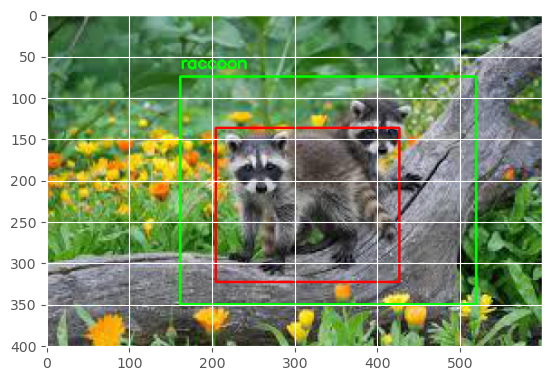

1/1 [==============================] - 0s 96ms/step


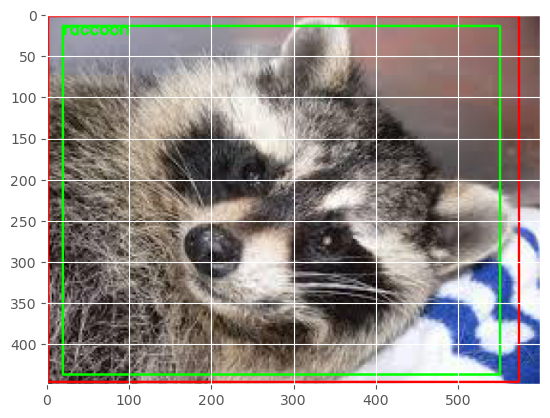

1/1 [==============================] - 0s 103ms/step


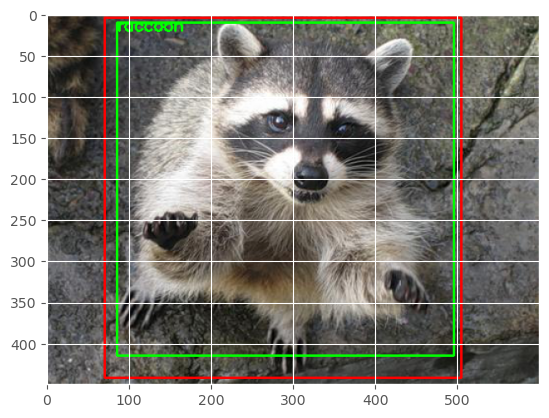

1/1 [==============================] - 0s 101ms/step


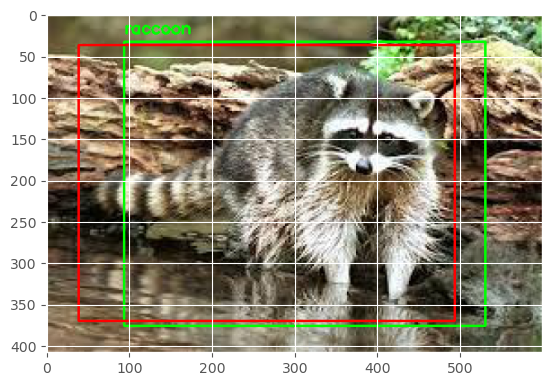

1/1 [==============================] - 0s 99ms/step


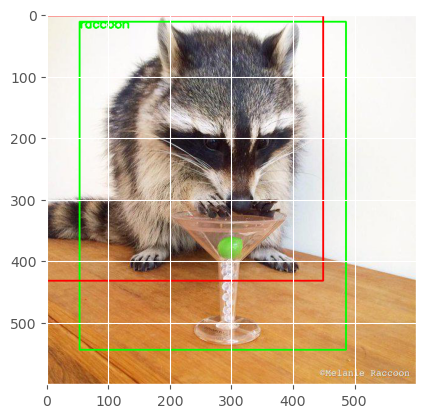

1/1 [==============================] - 0s 122ms/step


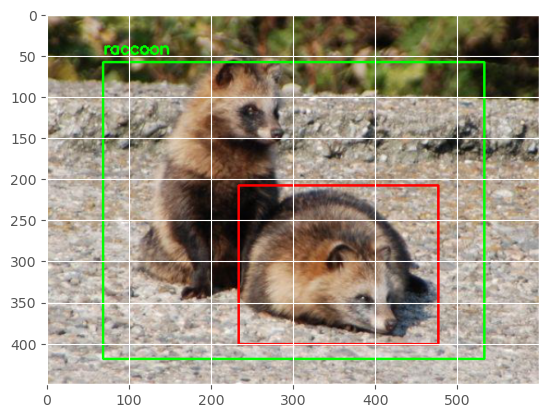

1/1 [==============================] - 0s 112ms/step


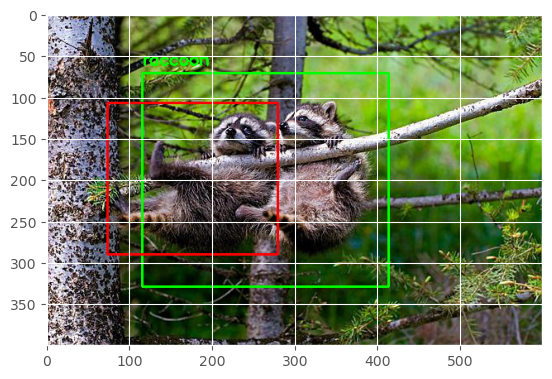

1/1 [==============================] - 0s 104ms/step


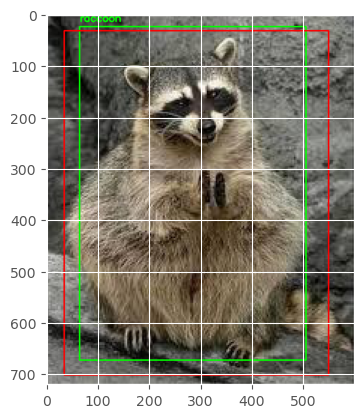

1/1 [==============================] - 0s 103ms/step


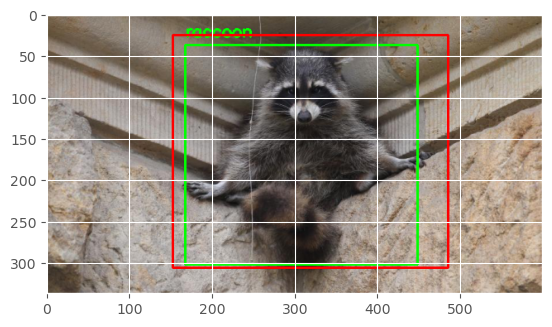

1/1 [==============================] - 0s 106ms/step


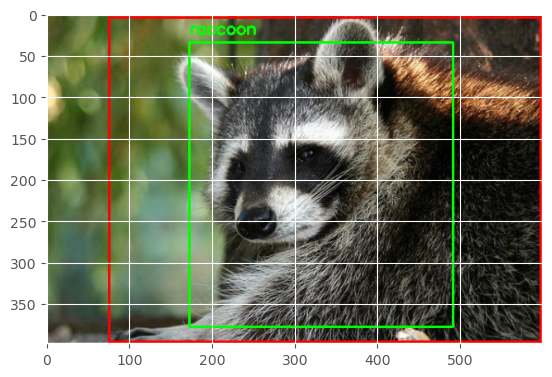

1/1 [==============================] - 0s 106ms/step


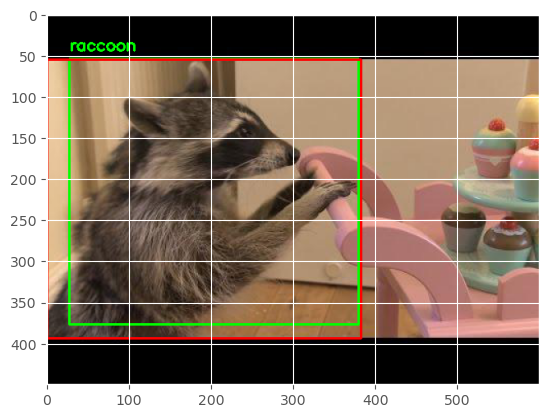

1/1 [==============================] - 0s 109ms/step


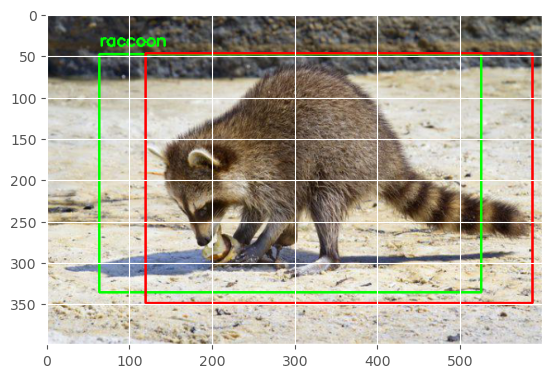

1/1 [==============================] - 0s 94ms/step


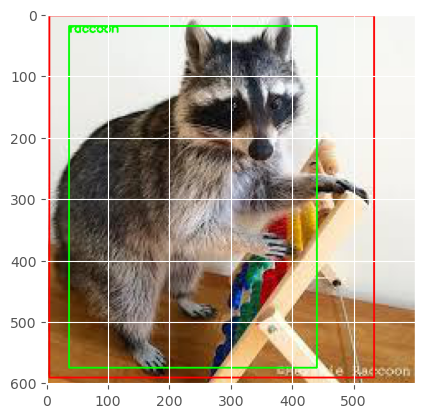

1/1 [==============================] - 0s 107ms/step


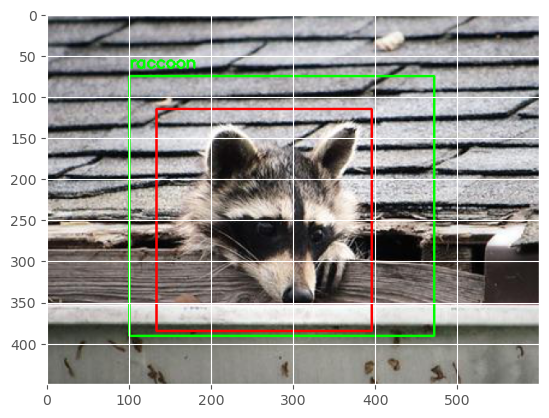

1/1 [==============================] - 0s 143ms/step


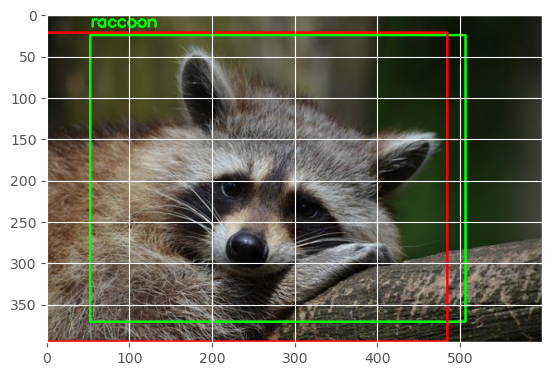

1/1 [==============================] - 0s 105ms/step


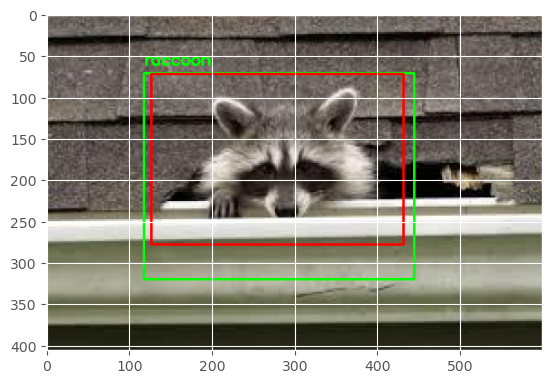

1/1 [==============================] - 0s 105ms/step


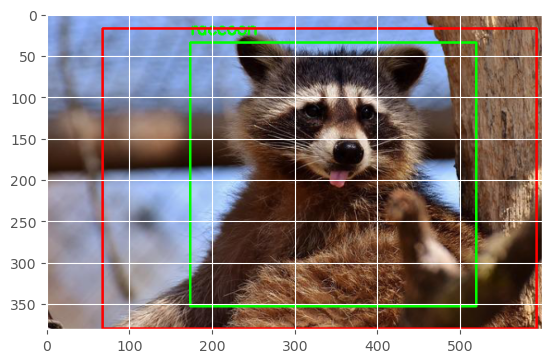

In [68]:
last_image_path = ""
for imagePath, label, bbox in zip(test_imagePaths, test_labels, test_bboxes):
    if imagePath == last_image_path:
        continue

    # Load the input image
    input_image = load_img(imagePath, target_size=(224, 224))
    input_image_array = img_to_array(input_image) / 255.0
    input_image_array = np.expand_dims(input_image_array, axis=0)
    
    # Predict coordinates and classes
    (box_predictions, label_predictions) = model.predict(input_image_array)
    (start_x, start_y, end_x, end_y) = box_predictions[0]
    
    # Determine the class label with the largest predicted probability
    predicted_class_index = np.argmax(label_predictions, axis=1)
    
    # Load the input image in OpenCV format
    original_image = cv2.imread(imagePath)
    resized_image = imutils.resize(original_image, width=600)
    
    # Scale the predicted bounding box coordinates based on the image dimensions
    start_x, start_y, end_x, end_y = scale_and_draw_bounding_box(resized_image, start_x, start_y, end_x, end_y,(0, 255, 0))
    
    # Draw the predicted bounding box and class label on the image
    label_text = "raccoon"
    text_start_y = start_y - 10 if start_y - 10 > 10 else start_y + 10
    cv2.putText(resized_image, label_text, (start_x, text_start_y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
    
    # Draw the ground truth bounding box in red
    (ground_truth_start_x, ground_truth_start_y, ground_truth_end_x, ground_truth_end_y) = bbox
    ground_truth_start_x, ground_truth_start_y, ground_truth_end_x, ground_truth_end_y = scale_and_draw_bounding_box(resized_image, ground_truth_start_x, ground_truth_start_y, ground_truth_end_x, ground_truth_end_y,(0, 0, 255))
        
    # Save the last image path
    last_image_path = imagePath
    
    # Show the output image
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB).astype('uint8'))
    plt.show()
